In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os
import warnings; warnings.simplefilter('ignore')
import fitsio
from astropy.table import Table

#sys.path.insert(0, '/global/homes/q/qmxp55/DESI/BGS_paper/')
from main_def import get_sweep_patch, cut, cut_sweeps, get_random_patch, get_area, flux_to_mag
from geometric_def import query_catalog_mask, LSLGA_fit, LSLGA_veto, circular_mask_radii_func, get_GM_stats, get_PM_stats, sky_PM
from photometric_def import get_stars, get_galaxies, get_photo_stats, plot_venn3, flow_1, flow_2

#import desitarget
#from desitarget.cuts import unextinct_fluxes


# params ini

In [2]:
#Starting up params...
rlimit = 20
N = 2
dr = 'dr8-south'
#define the square/rectangle patch of the sky in format [RAmin, RAmax, DECmin, DECmax]
main_patch = [195, 200, 5, 10]
#Main label
mainLab = '%s_%s_%s_%s' %(dr, '_'.join(str(i) for i in main_patch), 
                          str(rlimit), str(N))
    
mask_list = {
    #of the form: mask-Name: [applied or not, value(s) if any]
    #Geometrical (GEO) Cuts
    'BS_':[True, None, 'GM', 'Bright Stars', 'Circular (TYCHO2)'],
    'MS_':[False, None, 'GM', 'Medium Stars', 'Circular (GAIA DR2)'],
    'GC_':[True, None, 'GM', 'Globular Clusters', 'Circular (Unknown)'],
    'LG_':[True, None, 'GM', 'Large Galaxies', 'Elliptical (LSLGA)'],
    'allmask_':[False, 0, 'PM', 'ALLMASK', 'ALLMASK_{i} = 0, i=G,R and Z'], 
    'nobs_':[True, 1, 'PM', 'NOBS', 'NOBS_{i} > 0, i=G,R and Z'], 
    #Photometric (PHOT) Cuts
    'SG_':[True, 'gaia', 'PHOT', 'Galaxies with Gaia', '(G-rr > 0.6) or (G=0)'], #others: NoPSF 
    'FMC_':[True, 'v2', 'PHOT', None, ['rfib < 4.1 + r & r < 17.1', 'rfib < 21.2 & 17.7 < r < 18.3', 'rfib < 2.9 + r & r > 18.3']], #others: v1 (first version of FMC)
    'CC_':[True, [-1, 4], 'PHOT', None, ['-1 < g-r < 4', '-1 < r-z < 4']], 
    'QC_FM_':[True, 0.4, 'PHOTQC', 'FRACMASKED (FM)', 'fracmasked_{i}<0.4, i=G,R and Z'], 
    'QC_FI_':[True, 0.3, 'PHOTQC', 'FRACIN (FI)', 'fracin_{i}>0.3, i=G,R and Z'], 
    'QC_FF_':[True, 5.0, 'PHOTQC', 'FRACFLUX (FF)', 'fracflux_{i}<5, i=G,R and Z'], 
    'QC_IVAR_':[True, 0., 'PHOTQC', 'FLUXIVAR', 'flux_ivar_{i}>0, i=G,R and Z']
}        
    
#Cuts label
cutsLab = ''.join(str(i[0]*1) for i in list(mask_list.values()))

#directory name
ramin, ramax, decmin, decmax = main_patch[0], main_patch[1], main_patch[2], main_patch[3]
dir_name = '%s_%s_%s_%s_%s_rmag_%s_N_%s' %(dr, str(ramin), str(ramax), str(decmin), 
                                                 str(decmax), str(rlimit), str(N))
#Subdir name
subdir = '_'.join([mainLab, cutsLab])

print('dir Name: %s' %(dir_name))
print('subdir Name: %s' %(subdir))


dir Name: dr8-south_195_200_5_10_rmag_20_N_2
subdir Name: dr8-south_195_200_5_10_20_2_1011011111111


# GEOMETRICAL

## Data reduction

### SWEEP subsample

The SWEEP files from DECaLS DR7 are stored on:

    /global/project/projectdirs/cosmo/data/legacysurvey/dr7/sweep/7.1

Below we have an example on how to extract data from the SWEEP files. The function that extrac the data is called `get_sweep_patch` and requires the sky coordinates of a rectangle/square in format `[RAmin, RAmax, DECmin, DECmax]` and magnitude limit in the r-band with extinction correction. 

For this analysis we don't use the whole data, instead we focus on a big patch of the sky with coordinates:

        160 < RA < 230
        -2 < DEC < 18.

We have choosen this patch because it represents one of the most completenes region of the Legacy Survey and other surveys like...EXAMPLES OF OTHER SURVEYS WITHIN THIS FOOTPRINT...
The code below shows an example of how to extract the objects from the sweeps and to make things faster I am cutting off in total magnitude at 20. The whole process only took $111.49$ sec and the size of the catalogue created is $3.11$ GB with a total of $5455184$ objects.

The `get_sweep_patch` function can be called usging the following comand:

    sys.path.insert(0, '/global/homes/q/qmxp55/DESI/BGS_paper/')
    from main_def import get_sweep_patch

The first line contain the path where the main functions are stored and the second line call the needed function `get_sweep_patch` to extract the data from the SWEEPS. The `get_sweep_patch` function is located at main definitions file:

    /global/homes/q/qmxp55/DESI/BGS_paper/main_def.py
    
`df` is the subsample catalogue which was also stored at this notebook path

    /global/project/projectdirs/desi/users/qmxp55/BGS_paper/[sweep_subsample].npy
    
The catalogue was stored with numpy format `.npy` which is faster to write and read than `.fits`. 

The `get_sweep_patch` won't create duplicates for same patches in the sky neither will extract the data again if file is already there and instead this will load the catalogue.

If needed numpy data frames (`.npy`) can be read just typing:

    df = np.load('[sweep_subsample].npy')
    

In [3]:
dir_ = os.path.isdir(dir_name)

if dir_:
    print('The directory with %i < RA < %i, %i < DEC < %i, rmag limit=%2.2g and N=%i already exist...' 
          %(ramin, ramax, decmin, decmax, rlimit, N))
else:
    os.system('mkdir %s' %(dir_name))
    
subdir_ = os.path.isdir(dir_name+'/'+subdir)

if subdir_:
    print('The subdir %s/ already exist...' %(subdir))
else:
    os.system('mkdir %s' %(dir_name+'/'+subdir))

#get subsample catalogue
df = get_sweep_patch(patch=main_patch, rlimit=rlimit, dr=dr)

#give the right permissions to share the subsample catalogue
#!chmod 777 *.npy

The directory with 195 < RA < 200, 5 < DEC < 10, rmag limit=20 and N=2 already exist...
The subdir dr8-south_195_200_5_10_20_2_1011011111111/ already exist...
sweep file already exist at:/home/omar/bgs_pipeline/dr8-south_sweep_195_200_5_10_rmag_20.npy
Total run time: 0.000230 sec
Area of 195 < RA < 200 & 5 < DEC < 10: 24.78 deg^2
Weight of dr8-south_sweep_195_200_5_10_rmag_20.npy catalogue: 46.24 MB


### RANDOMS

To get the densities we are going to made use of the randoms created by the target selection team. Currently there's one random catalogue for each version of the `desitarget` pipeline and the last version that include the randoms is `0.29.0` but for some reason there's a problem in `MASKBITS` parameters that is why here we're going to take the last stable version (`0.22.0`) for DR7 stored here:

    /global/project/projectdirs/desi/target/catalogs/dr7.1/0.22.0/
  
The randoms are splitted into $10$ different `.fits` files covering very high densities. We don't require such that big densitites at this point and $\sim 5$ times more randoms than objects will be fine.

To select the randoms we use the function `get_random_patch` which is similar as the `get_sweep_patch` function and will extract the randoms from a patch coordinates of the form `[RAmin, RAmax, DECmin, DECmax]`. The `N` variable means how many of the randoms files available we want,for the patch we're working on `160 < RA < 230` and `-2 < DEC < 18` we require `N=3` to get $7.6$ times more randoms than objects within the patch. Last we have `sweepsize` that is just the size of the sweep catalogue to get the fraction of randoms over the seweeps. 

The whole process of extract the randoms takes only $\sim 30$ seconds for `N=3` and the choosen patch.

    *How many times bigger in the number of objects in the catalogue do we want for the randoms?
    *Shall we make a cut off as footprint patch?

In [4]:
df_ran = get_random_patch(patch=main_patch, N=N, sweepsize=len(df), dr=dr)

RANDOM file already exist at:/home/omar/bgs_pipeline/dr8-south_random_195_200_5_10_N_2.npy
Total run time: 0.001118 sec
Area of 195 < RA < 200 & 5 < DEC < 10: 24.78 deg^2
Weight of dr8-south_random_195_200_5_10_N_2.npy catalogue: 5.67 MB


plt.figure(figsize=(10,6))

plt.scatter(df_ran['RA'][::1000], df_ran['DEC'][::1000], alpha=0.7, s=0.3, label='DR8_randoms')
plt.scatter(df['RA'][::100], df['DEC'][::100], alpha=0.7, s=0.3, label='DR8_sweeps')

plt.legend()
plt.grid()
#plt.xlim(130, 141)
#plt.ylim(30, 36)

## Start up point
### prepare the data

In [5]:
#flux = unextinct_fluxes(df)

#gmag = 22.5 - 2.5*np.log10(flux['GFLUX'].clip(1e-16))
#rmag = 22.5 - 2.5*np.log10(flux['RFLUX'].clip(1e-16))
#zmag = 22.5 - 2.5*np.log10(flux['ZFLUX'].clip(1e-16))
#rfibmag = 22.5 - 2.5*np.log10(flux['RFIBERFLUX'].clip(1e-16))

rmag = flux_to_mag(df['FLUX_R']/df['MW_TRANSMISSION_R'])
gmag = flux_to_mag(df['FLUX_G']/df['MW_TRANSMISSION_G'])
zmag = flux_to_mag(df['FLUX_Z']/df['MW_TRANSMISSION_Z'])
rfibmag = flux_to_mag(df['FIBERFLUX_R']/df['MW_TRANSMISSION_R'])

bright = rmag < 19.5
faint = rmag > 19.5

nomask = np.zeros(len(df), dtype='?')
nomask_ran = np.zeros(len(df_ran), dtype='?')

In [6]:
A = get_area(patch=main_patch, get_val=True)

main_bright = np.sum(bright)/A
main_faint = np.sum(faint)/A

print('-------- Start up point --------')
print('AREA: %2.4g [sq.deg]' %(A))
print('Density Bright: %2.5g [1/sq.deg]' %(main_bright))
print('Density Faint: %2.5g [1/sq.deg]' %(main_faint))

Area of 195 < RA < 200 & 5 < DEC < 10: 24.78 deg^2
-------- Start up point --------
AREA: 24.78 [sq.deg]
Density Bright: 2596.1 [1/sq.deg]
Density Faint: 1040.6 [1/sq.deg]


## Geometric Masking (GM)

### Loading Tycho2 catalogue as Star catalogue

#Loading Tycho2 catalogue
path = '/global/homes/q/qmxp55/DESI/matches/'
tycho_ = fitsio.read(path+'tycho2.fits')
#cutting out to the same footprint as DECaLS catalogue
tycho = cut(main_patch[0], main_patch[1], main_patch[2], main_patch[3], tycho_)

### Loading LSLGA catalogue as Galaxy catalogue

#Loading the Legacy Survey Large Galaxy Atlas (href: https://github.com/moustakas/LSLGA)
LSLGA_ = fitsio.read('/global/project/projectdirs/desi/users/qmxp55/matches/LSLGA-v2.0.fits')
#cutting out to the same footprint as DECaLS catalogue
LSLGA = cut(main_patch[0], main_patch[1], main_patch[2], main_patch[3], LSLGA_)
masknans = (~np.isnan(LSLGA['PA'])) & (~np.isnan(LSLGA['BA'])) & (~np.isnan(LSLGA['D25']))
LSLGA['PA'][np.where(~masknans)] = 0

### mag-radii functions for TYCHO stars and LSLGA galaxies

In [7]:
#Rongpu's circ radii
rongpuLRG_radii = [[4.0, 210.],[4.5, 210.], [5.5, 200.], [6.25, 150.], [6.75, 125.],
                   [7.25, 120.], [7.75, 110.], [8.25, 100.], [8.75,  75.], [9.25,  60.],
                   [9.75,  55.], [ 10.25,  50.], [ 10.75,  48.], [ 11.25,  40.], [ 11.75,  37.], 
                   [ 12.25,  25.], [ 12.75,  20.], [ 13.25,  18.], [ 13.75,  16.], [ 14.25,  12.], 
                   [ 14.75,  11.], [ 15.25,  11.], [ 15.75,  10.]]

#Rongpu's length radii (diff spikes)
rongpuLRG_length_radii = [[4.0, 600.], [4.5, 600.], [5.5, 600.], [6.25, 540.], [6.75, 520.], [7.25, 500.], 
                   [7.75, 320.], [8.25, 300.], [8.75, 290.], [9.25, 160.], [9.75, 150.], [ 10.25, 140.],
                   [ 10.75, 130.], [ 11.25, 130.], [ 11.75, 100.], [ 12.25, 60.], [ 12.75, 40.], [ 13., 40.]]

#Rongpu's widht radii (diff spikes)
rongpuLRG_widht_radii = [[8., 25.], [13., 16.]]

#kyle_radii's = rongpuLRG_radii's/np.sqrt(2)
kyle_radii = []
for i in range(len(rongpuLRG_radii)):
    kyle_radii.append([rongpuLRG_radii[i][0], rongpuLRG_radii[i][1]/np.sqrt(2)])

kyle_length_radii = []
for i in range(len(rongpuLRG_length_radii)):
    kyle_length_radii.append([rongpuLRG_length_radii[i][0], rongpuLRG_length_radii[i][1]/np.sqrt(2)])

kyle_widht_radii = []
for i in range(len(rongpuLRG_widht_radii)):
    kyle_widht_radii.append([rongpuLRG_widht_radii[i][0], rongpuLRG_widht_radii[i][1]/np.sqrt(2)])

#LSLGA radii
LSLGA_radii = [[9.5,100], [10.5, 90], [11.5, 80], [12.5, 70], [13.5, 60], 
               [14.5, 50], [15.5, 35], [16.5, 25], [17.5, 15], [17.5, 10], [18, 8]]

#Dustin_radii's
mag = np.linspace(0, 20, 50)
Dustin_MS_radii = []
for i,j in enumerate(mag):
    Dustin_MS_radii.append([j, np.minimum(1800., 150. * 2.5**((11. - j)/3.)) * 0.262/1])

Results for the `GEOMETRICAL` part are given in three quantities, the `fraction of area` in percentage masked by each mask out of the total area ($f_{A}$) and the `densities` in square degrees in the `bright (B)` and `faint (F)` part ($\eta_{B}$, $\eta_{F}$),

$$f_{A}(i) = \frac{N_{R}(i)}{N_{R}}\times 100 [\%]$$
$$\eta_{B}(i)^* = N(i,B)/A$$
$$\eta_{B}(i) = N(i,B)/A(i)$$
where,
$$A(i) = \frac{N_{R}(i)}{N_{R}}A$$ 
and
$$i \equiv \{stars, LG, allmask, nobs, \sim(STARS | LG), \sim(STARS | LG | ALLMASK | NOBS), etc ...\}$$

The $^*$ means the density has not correction for the masked area.

### Get individual geometric cuts for BGS

In [8]:
def GetGeoCuts():
    
    #GEO cuts CATALOGUE
    BS = (np.uint64(df['MASKBITS']) & np.uint64(2**1))!=0
    MS = (np.uint64(df['MASKBITS']) & np.uint64(2**11))!=0
    GC = (np.uint64(df['MASKBITS']) & np.uint64(2**13))!=0
    LG = (np.uint64(df['MASKBITS']) & np.uint64(2**12))!=0
    allmask = ((df['MASKBITS'] & 2**6) != 0) | ((df['MASKBITS'] & 2**5) != 0) | ((df['MASKBITS'] & 2**7) != 0)
    nobs = (df['NOBS_G'] < mask_list['nobs_'][1]) | (df['NOBS_R'] < mask_list['nobs_'][1]) | (df['NOBS_Z'] < mask_list['nobs_'][1])

    #GEO cuts RANDOMS
    BS_ran = (np.uint64(df_ran['MASKBITS']) & np.uint64(2**1))!=0
    MS_ran = (np.uint64(df_ran['MASKBITS']) & np.uint64(2**11))!=0
    GC_ran = (np.uint64(df_ran['MASKBITS']) & np.uint64(2**13))!=0
    LG_ran = (np.uint64(df_ran['MASKBITS']) & np.uint64(2**12))!=0
    allmask_ran = ((df_ran['MASKBITS'] & 2**6) != 0) | ((df_ran['MASKBITS'] & 2**5) != 0) | ((df_ran['MASKBITS'] & 2**7) != 0)
    nobs_ran = (df_ran['NOBS_G'] < mask_list['nobs_'][1]) | (df_ran['NOBS_R'] < mask_list['nobs_'][1]) | (df_ran['NOBS_Z'] < mask_list['nobs_'][1])

    #GeoCut_ = [BS, MS, GC, LG, allmask, nobs]
    
    GeoCut = {'BS':BS,
              'MS':MS,
              'GC':GC,
              'LG':LG,
              'allmask':allmask,
              'nobs':nobs
             }
    
    GeoCut_ran = {'BS_ran':BS_ran,
              'MS_ran':MS_ran,
              'GC_ran':GC_ran,
              'LG_ran':LG_ran,
              'allmask_ran':allmask_ran,
              'nobs_ran':nobs_ran
             }
    
    #Replace with non-mask arrays (False bool-array) if cut is set False.
    for key in GeoCut.keys():
        if not mask_list[key + '_'][0]:
            #print(key+'_before', np.sum(GeoCut[key]))
            GeoCut[key] = nomask.copy()
            GeoCut_ran[key + '_ran'] = nomask_ran.copy()
            #print(key+'_after', np.sum(GeoCut[key]))
    
    return GeoCut, GeoCut_ran

GeoCut, GeoCut_ran = GetGeoCuts()

### Get statistics for geometric cuts

In [9]:
def GetGeoStats(GeoCutsDict, GeoCutsDict_ran, CurrentMask, PrevMask, A, B, F):
    
    from astropy.table import Table
    Tab = []
    GMT = np.zeros(len(list(GeoCutsDict.values())[0]), dtype='?')
    GMT_ran = np.zeros(len(list(GeoCutsDict_ran.values())[0]), dtype='?')
    PMT = GMT.copy()
    PMT_ran = GMT_ran.copy()
    
    if PrevMask is not None:
        PM_lab = '|'.join(PrevMask)
        for i in PrevMask:
            PMT |= GeoCutsDict[i]
            PMT_ran |= GeoCutsDict_ran[i+'_ran']   
    else:
        PM_lab = 'None'
    
    for i in CurrentMask:
        
        A_i = (np.sum((GeoCutsDict_ran[i+'_ran'] & (~PMT_ran)))/len(GeoCutsDict_ran[i+'_ran']))*(A)
        eta_B_i_in = np.sum((GeoCutsDict[i]) & (B) & (~PMT))/(A_i) #density over the geometric area
        eta_F_i_in = np.sum((GeoCutsDict[i]) & (F) & (~PMT))/(A_i) #density over the geometric area
        eta_B_i = np.sum((GeoCutsDict[i]) & (B) & (~PMT))/(A) #density over the total area
        eta_F_i = np.sum((GeoCutsDict[i]) & (F) & (~PMT))/(A) #density over the total area
        
        Tab.append([i, round(A_i*(100/A), 2), round(eta_B_i,2), round(eta_F_i,2)])
            
        GMT |= GeoCutsDict[i]
        GMT_ran |= GeoCutsDict_ran[i+'_ran']
    
  
    lab = '|'.join(CurrentMask)
    lab_in = '(%s)' %(lab)
    lab_out = '~(%s)*' %(lab)
    lab_out2 = '~(%s)' %(lab)
    
    A_GMT_in = (np.sum((GMT_ran) & (~PMT_ran))/len(GMT_ran))*(A)
    eta_B_GMT_in_1 = np.sum((GMT) & (B) & (~PMT))/(A) #Not corrected for mask area
    eta_F_GMT_in_1 = np.sum((GMT) & (F) & (~PMT))/(A) #Not corrected for mask area

    A_GMT_out = (np.sum((~GMT_ran) & (~PMT_ran))/len(GMT_ran))*(A)
    eta_B_GMT_out_1 = np.sum((~GMT) & (B) & (~PMT))/(A) #Not corrected for mask area
    eta_B_GMT_out_2 = np.sum((~GMT) & (B) & (~PMT))/(A_GMT_out) #Corrected for mask area
    eta_F_GMT_out_1 = np.sum((~GMT) & (F) & (~PMT))/(A) #Not corrected for mask area
    eta_F_GMT_out_2 = np.sum((~GMT) & (F) & (~PMT))/(A_GMT_out) #Corrected for mask area
    
    if len(CurrentMask) > 1:
        Tab.append([lab_in, round(A_GMT_in*(100/A),2), round(eta_B_GMT_in_1,2), round(eta_F_GMT_in_1,2)])
    Tab.append([lab_out, round(A_GMT_out*(100/A),2), round(eta_B_GMT_out_1,2), round(eta_F_GMT_out_1,2)])
    Tab.append([lab_out2, round(A_GMT_out*(100/A),2), round(eta_B_GMT_out_2,2), round(eta_F_GMT_out_2,2)])
    
    Tab = np.transpose(Tab)
    t = Table([Tab[0], Tab[1], Tab[2], Tab[3]], 
              names=('GM','$f_{A}$ [$\%$]', '$\eta_{B}$ [deg$^2$]', '$\eta_{F}$ [deg$^2$]'),
                    dtype=('S', 'f8', 'f8', 'f8'))
    
    print('Previous Cuts: (%s)' %(PM_lab))
    print('Current Cuts: %s' %(lab_in))
                                    
    return t


In [10]:
tG1 = GetGeoStats(GeoCutsDict=GeoCut, GeoCutsDict_ran=GeoCut_ran, CurrentMask=['BS', 'MS', 'GC', 'LG'], 
                 PrevMask=None, A=A, B=bright, F=faint)
tG1

Previous Cuts: (None)
Current Cuts: (BS|MS|GC|LG)


<Table length=7>
       GM       $f_{A}$ [$\%$] $\eta_{B}$ [deg$^2$] $\eta_{F}$ [deg$^2$]
    bytes15        float64           float64              float64       
--------------- -------------- -------------------- --------------------
             BS           1.88                88.71                13.32
             MS            0.0                  0.0                  0.0
             GC            0.0                  0.0                  0.0
             LG           0.12                42.05                  2.3
  (BS|MS|GC|LG)            2.0               130.15                15.54
~(BS|MS|GC|LG)*           98.0              2465.95              1025.05
 ~(BS|MS|GC|LG)           98.0              2516.31              1045.98

In [11]:
tG2 = GetGeoStats(GeoCutsDict=GeoCut, GeoCutsDict_ran=GeoCut_ran, CurrentMask=['allmask', 'nobs'], 
                 PrevMask=['BS', 'MS', 'GC', 'LG'], A=A, B=bright, F=faint)
tG2

Previous Cuts: (BS|MS|GC|LG)
Current Cuts: (allmask|nobs)


<Table length=5>
       GM        $f_{A}$ [$\%$] $\eta_{B}$ [deg$^2$] $\eta_{F}$ [deg$^2$]
    bytes16         float64           float64              float64       
---------------- -------------- -------------------- --------------------
         allmask            0.0                  0.0                  0.0
            nobs           0.06                 0.12                  0.0
  (allmask|nobs)           0.06                 0.12                  0.0
~(allmask|nobs)*          97.94              2465.83              1025.05
 ~(allmask|nobs)          97.94              2517.63              1046.59

# PHOTOMETRY

### Get individual potometric cuts for BGS

In [12]:
def GetPhotCuts():
    
    #Photometric cuts CATALOGUE
    STARS = get_stars(gaiagmag=df['GAIA_PHOT_G_MEAN_MAG'], fluxr=df['FLUX_R'])
    GAL = get_galaxies(gaiagmag=df['GAIA_PHOT_G_MEAN_MAG'], fluxr=df['FLUX_R'])
    
    FMCV1 = rfibmag < 2.9 + rmag
    FMCV2 = nomask.copy()
    FMCV2 |= ((rfibmag < (2.9 + 1.2) + rmag) & (rmag < 17.1))
    FMCV2 |= ((rfibmag < 21.2) & (rmag < 18.3) & (rmag > 17.1))
    FMCV2 |= ((rfibmag < 2.9 + rmag) & (rmag > 18.3))
    FMC = ~nomask.copy()
    if mask_list['FMC_'][1] is 'v1':
        FMC &= FMCV1
    elif mask_list['FMC_'][1] is 'v2':
        FMC &= FMCV2
    else:
        print('Choose either V1 or V2 for FMC...')
    
    CC = ~nomask.copy()
    CC &= ((gmag - rmag) > mask_list['CC_'][1][0]) 
    CC &= ((gmag - rmag) < mask_list['CC_'][1][1]) 
    CC &= ((rmag - zmag) > mask_list['CC_'][1][0]) 
    CC &= ((rmag - zmag) < mask_list['CC_'][1][1])

    QC_FM = ~nomask.copy()
    QC_FM &= (df['FRACMASKED_R'] < mask_list['QC_FM_'][1]) 
    QC_FM &= (df['FRACMASKED_G'] < mask_list['QC_FM_'][1]) 
    QC_FM &= (df['FRACMASKED_Z'] < mask_list['QC_FM_'][1])
    
    QC_FI = ~nomask.copy()
    QC_FI &= (df['FRACIN_R'] > mask_list['QC_FI_'][1]) 
    QC_FI &= (df['FRACIN_G'] > mask_list['QC_FI_'][1]) 
    QC_FI &= (df['FRACIN_Z'] > mask_list['QC_FI_'][1])
    
    QC_FF = ~nomask.copy()
    QC_FF &= (df['FRACFLUX_R'] < mask_list['QC_FF_'][1]) 
    QC_FF &= (df['FRACFLUX_G'] < mask_list['QC_FF_'][1]) 
    QC_FF &= (df['FRACFLUX_Z'] < mask_list['QC_FF_'][1])
    
    QC_IVAR = ~nomask.copy()
    QC_IVAR &= (df['FLUX_IVAR_R'] > mask_list['QC_IVAR_'][1]) 
    QC_IVAR &= (df['FLUX_IVAR_G'] > mask_list['QC_IVAR_'][1]) 
    QC_IVAR &= (df['FLUX_IVAR_Z'] > mask_list['QC_IVAR_'][1])

    
    PhotCut = {'SG':GAL,
              'FMC':FMC,
              'CC':CC,
              'QC_FM':QC_FM,
              'QC_FI':QC_FI,
              'QC_FF':QC_FF,
              'QC_IVAR':QC_IVAR
             }
    
    #Replace with non-mask arrays (True bool-array) if cut is set False.
    for key in PhotCut.keys():
        if not mask_list[key + '_'][0]:
            #print(key+'_before', np.sum(photCut[key]))
            PhotCut[key] = ~nomask.copy()
            #print(key+'_after', np.sum(photCut[key]))
    
    return PhotCut

PhotCut = GetPhotCuts()

In [13]:
def GetPhotoStats(GeoCutsDict, GeoCutsDict_ran, PhotCutsDict, CurrentMask, 
                 PrevMask, A, B, F):
    
    from astropy.table import Table
    GMT_ran = nomask_ran.copy()
    PMT = nomask.copy()
    CMT = nomask.copy()
    
    for i in PrevMask:
        if i in GeoCutsDict.keys():
            GMT_ran |= GeoCutsDict_ran[i+'_ran']
    
    #totmask = np.ones_like(mask, dtype='?')
    Tab = []
    A_G_out = (np.sum(~GMT_ran)/len(GMT_ran))*(A)
    
    PM_lab = []
    for i in PrevMask:
        if i in GeoCutsDict.keys():
            PMT |= GeoCutsDict[i]
            PM_lab.append('~%s' %(i))
        elif i in PhotCutsDict.keys():
            PMT |= ~PhotCutsDict[i]
            PM_lab.append('%s' %(i))
        else:
            print('%s is neither in GeoCuts or PhotCuts...')
    
    for i in CurrentMask:
        CM_lab = '~%s' %(i)
        eta_B_in = np.sum((~PhotCutsDict[i]) & (~PMT) & (B))/(A_G_out)
        eta_F_in = np.sum((~PhotCutsDict[i]) & (~PMT) & (F))/(A_G_out)
        eta_B_in, eta_F_in = round(eta_B_in, 2), round(eta_F_in, 2)
        Tab.append([CM_lab, eta_B_in, eta_F_in])
        CMT |= ~PhotCutsDict[i]
        
    if len(CurrentMask) > 1:
        CMT_lab_in = '~(%s)' %('&'.join(CurrentMask))
        CMT_lab_out = '(%s)' %('&'.join(CurrentMask))
        eta_B_inT = np.sum((CMT) & (~PMT) & (B))/(A_G_out)
        eta_F_inT = np.sum((CMT) & (~PMT) & (F))/(A_G_out)
        eta_B_inT, eta_F_inT = round(eta_B_inT, 2), round(eta_F_inT, 2)
        Tab.append([CMT_lab_in, eta_B_inT, eta_F_inT])
    else:
        CMT_lab_out = '(%s)' %(CurrentMask[0])
        
    eta_B_outT = np.sum((~CMT) & (~PMT) & (B))/(A_G_out) #Corrected for mask area
    eta_F_outT = np.sum((~CMT) & (~PMT) & (F))/(A_G_out) #Corrected for mask area
    eta_B_outT, eta_F_outT = round(eta_B_outT, 2), round(eta_F_outT, 2)
    Tab.append([CMT_lab_out, eta_B_outT, eta_F_outT])
    
    Tab = np.transpose(Tab)
    t = Table([Tab[0], Tab[1], Tab[2]], names=('PHOTOMETRY','$\eta_{B}$ [deg$^2$]', '$\eta_{F}$ [deg$^2$]'),
             dtype=('S', 'f8', 'f8'))
    
    print('Previous Cuts: (%s)' %(' & '.join(PM_lab)))
    print('Current Cuts: %s' %(CMT_lab_out))
        
    return t

t = GetPhotoStats(GeoCutsDict=GeoCut, GeoCutsDict_ran=GeoCut_ran, PhotCutsDict=PhotCut, CurrentMask=['QC_FM', 'QC_FI', 'QC_FF', 'QC_IVAR'], 
                 PrevMask=['BS', 'MS', 'GC', 'LG', 'allmask', 'nobs', 'SG', 'CC', 'FMC'], A=A, B=bright, F=faint)

t

Previous Cuts: (~BS & ~MS & ~GC & ~LG & ~allmask & ~nobs & SG & CC & FMC)
Current Cuts: (QC_FM&QC_FI&QC_FF&QC_IVAR)


<Table length=6>
         PHOTOMETRY          $\eta_{B}$ [deg$^2$] $\eta_{F}$ [deg$^2$]
          bytes28                  float64              float64       
---------------------------- -------------------- --------------------
                      ~QC_FM                 3.09                  1.9
                      ~QC_FI                 0.29                 0.25
                      ~QC_FF                 2.27                 1.69
                    ~QC_IVAR                  0.0                  0.0
~(QC_FM&QC_FI&QC_FF&QC_IVAR)                 4.94                 3.75
 (QC_FM&QC_FI&QC_FF&QC_IVAR)               866.76               628.88

# FLOW CHARTS...

In [14]:
from photometric_def import masking, results
import pygraphviz as pgv
from PIL import Image

def flow_1(file, GeoCutsDict, GeoCutsDict_ran, A, B, F, patch, mask_list, dr, rlimit):
    
    T = Table()
    
    IGMSubLab, IGMDetLab = [], []
    IPMSubLab, IPMDetLab = [], []
    IGMLab, IPMLab = [], []
    for i in mask_list.keys():
        #get submasks and details for Geometrical Mask set True
        if ('GM' in mask_list[i][2]) and mask_list[i][0]:
            IGMSubLab.append(mask_list[i][3])
            IGMDetLab.append(mask_list[i][4])
            IGMLab.append(i[:-1])
        #get submasks and details for Pixel Mask set True
        elif ('PM' in mask_list[i][2]) and mask_list[i][0]:
            IPMSubLab.append(mask_list[i][3])
            IPMDetLab.append(mask_list[i][4])
            IPMLab.append(i[:-1])
            
    #Results  for Geometrical Mask
    tGM = GetGeoStats(GeoCutsDict=GeoCutsDict, GeoCutsDict_ran=GeoCutsDict_ran, CurrentMask=IGMLab, 
                 PrevMask=None, A=A, B=B, F=F)
    
    #Results  for Pixel Mask
    tPM = GetGeoStats(GeoCutsDict=GeoCutsDict, GeoCutsDict_ran=GeoCutsDict_ran, CurrentMask=IPMLab, 
                 PrevMask=IGMLab, A=A, B=B, F=F)

    T['SU'] = masking(title='START', submasks=None, details=None)
    T['SG'] = masking(title='GEOMETRICAL', submasks=None, details=None)

    T['I'] = masking(title='DECaLS %s' %(dr), submasks=['rmag < %2.2g' %(rlimit), '%i < RA < %i' %(patch[0], patch[1]), 
                                              '%i < DEC < %i' %(patch[2], patch[3])], details=None)
    
    T['IGM'] = masking(title='Geometric Masking', submasks=IGMSubLab, details=IGMDetLab)
    T['IPM'] = masking(title='Pixel Masking', submasks=IPMSubLab, details=IPMDetLab)

    #RESULTS...
    T['RI'] = results(a=A, b=np.sum(B)/A, f=np.sum(F)/A, stage='ini', per=False)

    T['RGM'] = results(a=tGM[-2][1], b=tGM[-2][2], f=tGM[-2][3], b2=tGM[-1][2], f2=tGM[-1][3], stage='geo', per=True)
    T['RPM'] = results(a=tPM[-2][1], b=tPM[-2][2], f=tPM[-2][3], b2=tPM[-1][2], f2=tPM[-1][3], stage='geo', per=True)
    
    
    #REJECTED by GM...
    for i, j in enumerate(IGMLab):
        T['RGM_' + j] = results(a=tGM[i][1], b=tGM[i][2], f=tGM[i][3], stage='ini', per=True, title=IGMSubLab[i])
    if len(IGMLab) > 1:
        IGMLab_2 = '|'.join(IGMLab)
    else:
        IGMLab_2 = IGMLab[0]
    T['RGMR'] = results(a=tGM[-3][1], b=tGM[-3][2], f=tGM[-3][3], stage='ini', per=True, title='(%s)' %(IGMLab_2))
    
    #REJECTED by PM...
    for i, j in enumerate(IPMLab):
        T['RPM_' + j] = results(a=tPM[i][1], b=tPM[i][2], f=tPM[i][3], stage='ini', per=True, title=IPMSubLab[i])
    if len(IPMLab) > 1:
        IPMLab_2 = '|'.join(IPMLab)
    else:
        IPMLab_2 = IPMLab[0]
    T['RPMR'] = results(a=tPM[-3][1], b=tPM[-3][2], f=tPM[-3][3], stage='ini', per=True, title='(%s)' %(IPMLab_2))
    
    G=pgv.AGraph(strict=False,directed=True)

    elist = []
    rejLab = []
    #define initial params in flow chart
    ini = ['SU', 'I', 'RI', 'SG', 'IGM', 'RGM', 'IPM', 'RPM']
    for i in range(len(ini) - 1):
        elist.append((list(T[ini[i]]),list(T[ini[i+1]])))
    
    #define GM rejections
    if len(IGMLab) > 0:
        if len(IGMLab) > 1:
            rejLab.append('RGMR')
            elist.append((list(T['IGM']),list(T['RGMR'])))
            for i, j in enumerate(IGMLab):
                elist.append((list(T['RGMR']),list(T['RGM_' + j])))
                rejLab.append('RGM_' + j)
        else:
            elist.append((list(T['IGM']),list(T['RGM_' + IGMLab[0]])))
            rejLab.append('RGM_' + IGMLab[0])
    
    #define PM rejections
    if len(IPMLab) > 0:
        if len(IPMLab) > 1:
            rejLab.append('RPMR')
            elist.append((list(T['IPM']),list(T['RPMR'])))
            for i, j in enumerate(IPMLab):
                elist.append((list(T['RPMR']),list(T['RPM_' + j])))
                rejLab.append('RPM_' + j)
        else:
            elist.append((list(T['IPM']),list(T['RPM_' + IPMLab[0]])))
            rejLab.append('RPM_' + IPMLab[0])
    
    G.add_edges_from(elist)
    
    stages=['SU', 'SG']
    G.add_nodes_from([list(T[i]) for i in stages], color='green', style='filled')

    nlist=['RI', 'RGM', 'RPM']
    G.add_nodes_from([list(T[i]) for i in nlist], color='deepskyblue', shape='box', style='filled')
    
    maskings=['I', 'IGM', 'IPM']
    G.add_nodes_from([list(T[i]) for i in maskings], color='gold', style='filled')

    G.add_nodes_from([list(T[i]) for i in rejLab], color='coral', shape='box', style='filled')

    G.write('%s.dot' %(file)) # write to simple.dot
    BB=pgv.AGraph('%s.dot' %(file)) # create a new graph from file
    BB.layout(prog='dot') # layout with default (neato)
    BB.draw('%s.ps' %(file)) # draw png
    os.system('convert ' + file + '.ps ' + file + '.png')
    flow = Image.open('%s.png' %(file))

    return flow


Previous Cuts: (None)
Current Cuts: (BS|GC|LG)
Previous Cuts: (BS|GC|LG)
Current Cuts: (nobs)


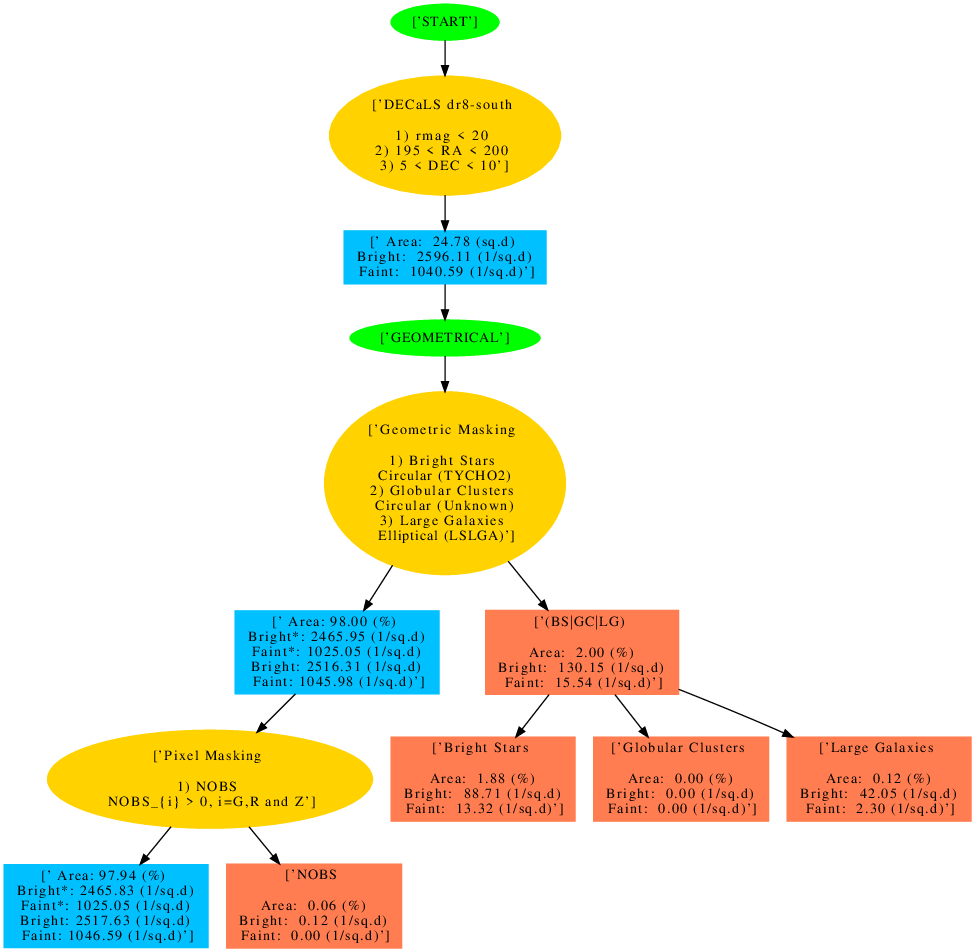

In [15]:
flow = flow_1(file='%s/%s/flow_1' %(dir_name, subdir), GeoCutsDict=GeoCut, GeoCutsDict_ran=GeoCut_ran, A=A, B=bright, F=faint, 
                      patch=main_patch, mask_list=mask_list, dr=dr, rlimit=rlimit)
flow

In [16]:
def flow_2(file, GeoCutsDict, GeoCutsDict_ran, PhotCutsDict, A, B, F, mask_list):
    
    T = Table()
    
    T['SP'] = ISG = masking(title='PHOTOMETRY', submasks=None, details=None)
    
    if mask_list['SG_'][0]:
        T['ISG'] = masking(title='Star-Galaxy Separation', submasks=[mask_list['SG_'][3]], details=[mask_list['SG_'][4]])
    
    if mask_list['FMC_'][0]:
        T['IFMC'] = masking(title='Fibre Magnitude Cut (FMC)', submasks=mask_list['FMC_'][3], details=mask_list['FMC_'][4])
        
    if mask_list['CC_'][0]:   
        T['ICC'] = masking(title='Colour Cuts', submasks=mask_list['CC_'][3], details=mask_list['CC_'][4])
        
    IQCSubLab, IQCDetLab, IQCLab = [], [], []
    IPHOTLab = []
    for i in mask_list.keys():
        #get submasks and details for PHOTQC Mask set True
        if ('PHOTQC' in mask_list[i][2]) and mask_list[i][0]:
            IQCSubLab.append(mask_list[i][3])
            IQCDetLab.append(mask_list[i][4])
            IQCLab.append(i[:-1])
        elif ('PHOT' in mask_list[i][2]) and mask_list[i][0]:
            IPHOTLab.append(i[:-1])
    
    IGMLab, IPMLab = [], []
    for i in mask_list.keys():
        #get submasks and details for Geometrical Mask set True
        if ('GM' in mask_list[i][2]) and mask_list[i][0]:
            IGMLab.append(i[:-1])
        #get submasks and details for Pixel Mask set True
        elif ('PM' in mask_list[i][2]) and mask_list[i][0]:
            IPMLab.append(i[:-1])
    
    if len(IQCLab) > 0:
        T['IQC'] = masking(title='Quality Cuts', submasks=IQCSubLab, details=IQCDetLab)
        
    #Results  for Pixel Mask
    tPM = GetGeoStats(GeoCutsDict=GeoCutsDict, GeoCutsDict_ran=GeoCutsDict_ran, CurrentMask=IPMLab, 
                 PrevMask=IGMLab, A=A, B=B, F=F)
    
    T['RI'] = results(a=tPM[-1][1]*(A/100), b=tPM[-1][2], f=tPM[-1][3], stage='ini', per=False)
    
    #Results and rejects for PHOT Mask
    for i, j in enumerate(IPHOTLab):
        t = GetPhotoStats(GeoCutsDict=GeoCutsDict, GeoCutsDict_ran=GeoCutsDict_ran, PhotCutsDict=PhotCutsDict, CurrentMask=[j], 
                 PrevMask=np.concatenate((IGMLab, IPMLab, IPHOTLab[:i])), A=A, B=bright, F=faint)
        T['R' + j] = results(b=t[1][1], f=t[1][2], stage='photo', per=True)
        T['R' + j + 'R'] = results(b=t[0][1], f=t[0][2], stage='photo', per=True, title=j)
        
    #Results and rejects for PHOTQC Mask
    if len(IQCLab) > 0:
        t = GetPhotoStats(GeoCutsDict=GeoCutsDict, GeoCutsDict_ran=GeoCutsDict_ran, PhotCutsDict=PhotCutsDict, CurrentMask=IQCLab, 
                 PrevMask=np.concatenate((IGMLab, IPMLab, IPHOTLab)), A=A, B=bright, F=faint)
        T['RQC'] = results(b=t[-1][1], f=t[-1][2], stage='photo', per=True)
        T['RQCR'] = results(b=t[-2][1], f=t[-2][2], stage='photo', per=True, title='(%s)' %('|'.join(IQCLab)))
        for i, j in enumerate(IQCLab):
            t = GetPhotoStats(GeoCutsDict=GeoCutsDict, GeoCutsDict_ran=GeoCutsDict_ran, PhotCutsDict=PhotCutsDict, CurrentMask=[j], 
                     PrevMask=np.concatenate((IGMLab, IPMLab, IPHOTLab)), A=A, B=bright, F=faint)
            T['R' + j + 'R'] = results(b=t[0][1], f=t[0][2], stage='photo', per=True, title=j)
    
    G=pgv.AGraph(strict=False,directed=True)

    elist = []
    rejLab, resLab, ILab = [], [], []
    #define initial params in flow chart
    ini = ['RI', 'SP']
    for i, j in enumerate(IPHOTLab):
        ini.append('I' + j)
        ini.append('R' + j)
        ILab.append('I' + j)
        resLab.append('R' + j)
    if len(IQCLab) > 0:
        ini.append('IQC')
        ini.append('RQC')
        ILab.append('IQC')
        resLab.append('RQC')
        
    for i in range(len(ini) - 1):
        elist.append((list(T[ini[i]]),list(T[ini[i+1]])))
    
    #define PHOT rejections
    if len(IPHOTLab) > 0:
        for i, j in enumerate(IPHOTLab):
                elist.append((list(T['I' + j]),list(T['R' + j + 'R'])))
                rejLab.append('R' + j + 'R')
    
    #define PHOTQC rejections
    if len(IQCLab) > 0:  
        if len(IQCLab) > 1:
            rejLab.append('RQCR')
            elist.append((list(T['IQC']),list(T['RQCR'])))
            for i, j in enumerate(IQCLab):
                elist.append((list(T['RQCR']),list(T['R' + j + 'R'])))
                rejLab.append('R' + j + 'R')
        else:
            elist.append((list(T['IQC']),list(T['R' + IQCLab[0] + 'R'])))
            rejLab.append('R' + IQCLab[0] + 'R')
    
    G.add_edges_from(elist)
    
    stages=['SP']
    G.add_nodes_from([list(T[i]) for i in stages], color='green', style='filled')

    resLab.append('RI')
    G.add_nodes_from([list(T[i]) for i in resLab], color='deepskyblue', shape='box', style='filled')
    
    G.add_nodes_from([list(T[i]) for i in ILab], color='gold', style='filled')

    G.add_nodes_from([list(T[i]) for i in rejLab], color='coral', shape='box', style='filled')

    G.write('%s.dot' %(file)) # write to simple.dot
    BB=pgv.AGraph('%s.dot' %(file)) # create a new graph from file
    BB.layout(prog='dot') # layout with default (neato)
    BB.draw('%s.ps' %(file)) # draw png
    os.system('convert ' + file + '.ps ' + file + '.png')
    flow = Image.open('%s.png' %(file))

    return flow


Previous Cuts: (BS|GC|LG)
Current Cuts: (nobs)
Previous Cuts: (~BS & ~GC & ~LG & ~nobs)
Current Cuts: (SG)
Previous Cuts: (~BS & ~GC & ~LG & ~nobs & SG)
Current Cuts: (FMC)
Previous Cuts: (~BS & ~GC & ~LG & ~nobs & SG & FMC)
Current Cuts: (CC)
Previous Cuts: (~BS & ~GC & ~LG & ~nobs & SG & FMC & CC)
Current Cuts: (QC_FM&QC_FI&QC_FF&QC_IVAR)
Previous Cuts: (~BS & ~GC & ~LG & ~nobs & SG & FMC & CC)
Current Cuts: (QC_FM)
Previous Cuts: (~BS & ~GC & ~LG & ~nobs & SG & FMC & CC)
Current Cuts: (QC_FI)
Previous Cuts: (~BS & ~GC & ~LG & ~nobs & SG & FMC & CC)
Current Cuts: (QC_FF)
Previous Cuts: (~BS & ~GC & ~LG & ~nobs & SG & FMC & CC)
Current Cuts: (QC_IVAR)


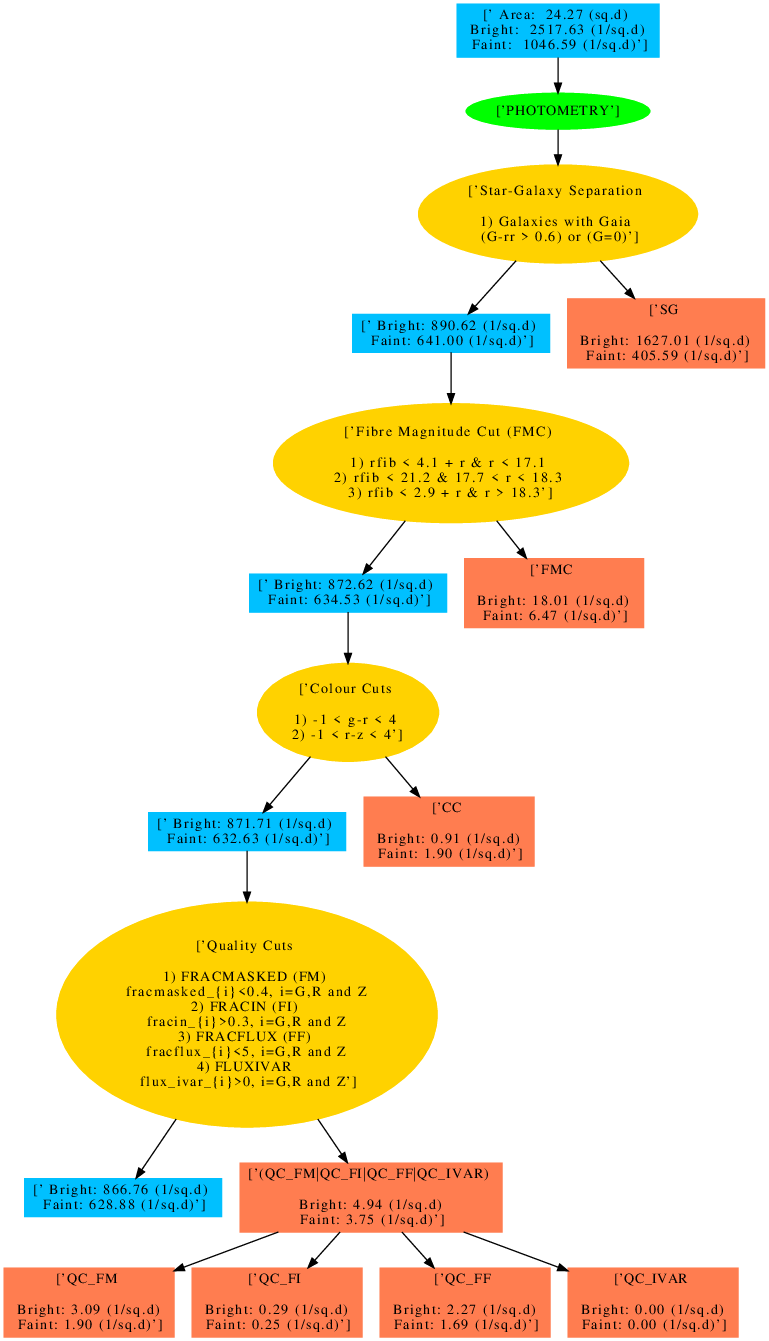

In [17]:
flow2 = flow_2(file='%s/%s/flow_2' %(dir_name, subdir), GeoCutsDict=GeoCut, GeoCutsDict_ran=GeoCut_ran, 
                      PhotCutsDict=PhotCut, A=A, B=bright, F=faint, mask_list=mask_list)
flow2

# PLOTS
## Venn Diagrams
### Geometric Masking
### Quality cuts

## Star-Galaxy 
Plot $G-rr$ Vs $r-z$ divided into `PSF` and `no-PSF`. Include distributions in $G-rr$
This plot is at its stage, tha means we have to use data with cuts on Geometrical and Pixel only, it's previous cuts according to flow chart.

## Fibre Magnitude Cut
Plot $rfib$ Vs $r$ in hexbin format and draw the FMC cut on top. If the tail at bottom appears, get a sample of postage images.
This plot is at its stage, tha means we have to use data with cuts on Geometrical, Pixel and SG only, it's previous cuts according to flow chart.


# Define BGS catalogue...

## masking column...

In [45]:
mask_lab = [] #Catalogue
for i in range(len(nobs)):
    
    if (dr == 'dr8-south') or (dr == 'dr8-north'):
        #lab = (GM[0][i] | GM[1][i])*'1'+(nobs[i])*'2'+(allmask[i])*'3'+(STARS[i])*'4'+(~FMC[i])*'5'+(~CC[i])*'6'+(~QC[i])*'7'
        lab = (GM[0][i])*'0'+(GM[1][i])*'1'+(GM[2][i])*'2'+(nobs[i])*'3'+(allmask[i])*'4'+(STARS[i])*'5'+(~FMC[i])*'6'+(~CC[i])*'7'+(~QC[i])*'8'
    if dr is 'dr7':
        lab = (GM[0][i])*'0'+(GM[1][i])*'1'+(nobs[i])*'2'+(allmask[i])*'3'+(STARS[i])*'4'+(~FMC[i])*'5'+(~CC[i])*'6'+(~QC[i])*'7'
        
    mask_lab.append(lab)

mask_lab = np.array(mask_lab)

mask_lab_ran = [] #Randoms
for i in range(len(df_ran)):
    
    lab_ran = (GM_ran[0][i])*'0'+(GM_ran[1][i])*'1'+(nobs_ran[i])*'2'+(allmask_ran[i])*'3'

    mask_lab_ran.append(lab_ran)

mask_lab_ran = np.array(mask_lab_ran)

In [48]:
bgs = mask_lab == '' #bgs targets

BS_all = np.zeros(len(df), dtype='?') #All BS. Equivalent to GM[0]
for i, j in enumerate(mask_lab):
    #print(i)
    if '0' in j:
        BS_all[i] = True

BS_only = np.zeros(len(df), dtype='?') #Only BS
BS_only |= mask_lab == '0'


## Are LSLGA galaxies beeing removed by geometrical masking?

To check this will be enough to match the BGS catalogue with LSLGA, and we can see there's no match at all. Then yes, they're being removed.

In [89]:
idx2, idx1, d2d, d_ra, d_dec = search_around(LSLGA['RA'], LSLGA['DEC'], 
                                             df[bgs]['RA'], df[bgs]['DEC'], search_radius=0.05)

97 nearby objects ~ 0.00505608 %


# PLOTS

## 2D-stacks...

8.00 < MAG_VT < 9.00
43456 nearby objects ~ 2.22199 %
mag_radii MAX: 98.40440684803087 mag_radii MIN: 72.43789514112603
mag MAX: 8.999 mag MIN: 8.001
d2d min=0.0436, d2d max=4.13
295 of inf in density ratio out of a total of 7556
Minimum density ratio = -4, Maximum density ratio = 4.55762
----------------
9.00 < MAG_VT < 10.00
98898 nearby objects ~ 5.05684 %
mag_radii MAX: 72.39604267815174 mag_radii MIN: 53.458267411998776
mag MAX: 9.999 mag MIN: 9.001
d2d min=0.023, d2d max=5.61
152 of inf in density ratio out of a total of 7556
Minimum density ratio = -4, Maximum density ratio = 4.76544
----------------
10.00 < MAG_VT < 11.00
230069 nearby objects ~ 11.7639 %
mag_radii MAX: 53.425650861738575 mag_radii MIN: 39.32777443146366
mag MAX: 10.999 mag MIN: 10.001
d2d min=0.0166, d2d max=7.62
60 of inf in density ratio out of a total of 7556
Minimum density ratio = -4, Maximum density ratio = 4.38041
----------------


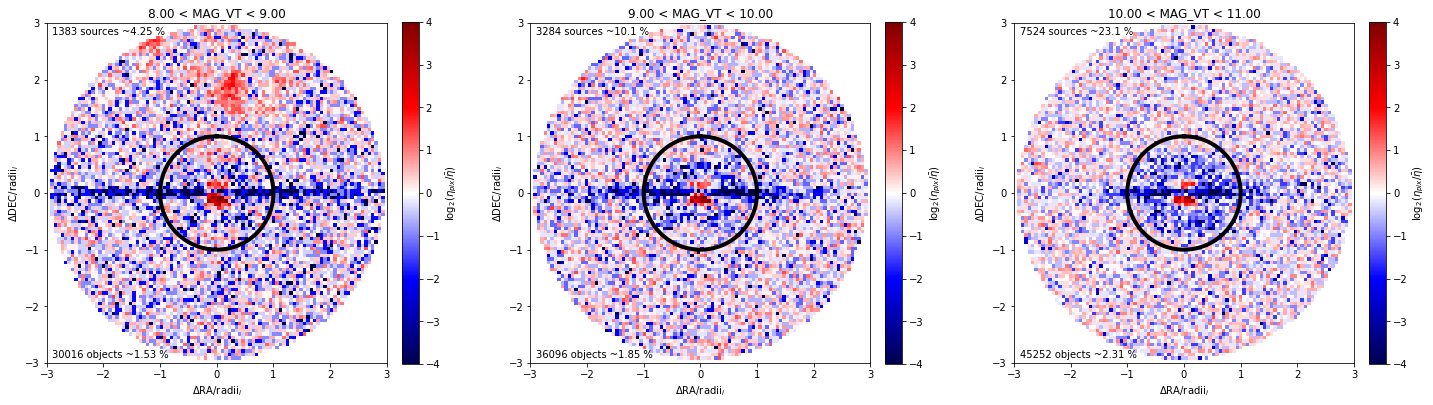

In [90]:
_ = overdensity(df[(bgs) | (BS_only)], tycho, Dustin_MS_radii, 'MAG_VT', 35, density=False, 
                            magbins=(8,11,3), radii_2=None, grid=[1,3], SR=[1., 300.], scaling=True, nbins=101, 
                               SR_scaling=3,logDenRat=[-4, 4], radii_bestfit=False, annulus=None, eqbined=True, 
                                   filename='%s/%s/2d_stacks_bgs_noBS_SR_300' %(dir_name, subdir))

8.00 < MAG_VT < 9.00
36530 nearby objects ~ 1.90411 %
mag_radii MAX: 98.40440684803087 mag_radii MIN: 72.43789514112603
mag MAX: 8.999 mag MIN: 8.001
d2d min= 1, d2d max=4.13
1107 of inf in density ratio out of a total of 7556
Minimum density ratio = -4, Maximum density ratio = 1.96545
----------------
9.00 < MAG_VT < 10.00
92930 nearby objects ~ 4.84394 %
mag_radii MAX: 72.39604267815174 mag_radii MIN: 53.458267411998776
mag MAX: 9.999 mag MIN: 9.001
d2d min= 1, d2d max=5.61
938 of inf in density ratio out of a total of 7556
Minimum density ratio = -4, Maximum density ratio = 1.99514
----------------
10.00 < MAG_VT < 11.00
221523 nearby objects ~ 11.5468 %
mag_radii MAX: 53.425650861738575 mag_radii MIN: 39.32777443146366
mag MAX: 10.999 mag MIN: 10.001
d2d min= 1, d2d max=7.62
855 of inf in density ratio out of a total of 7556
Minimum density ratio = -4, Maximum density ratio = 1.54897
----------------


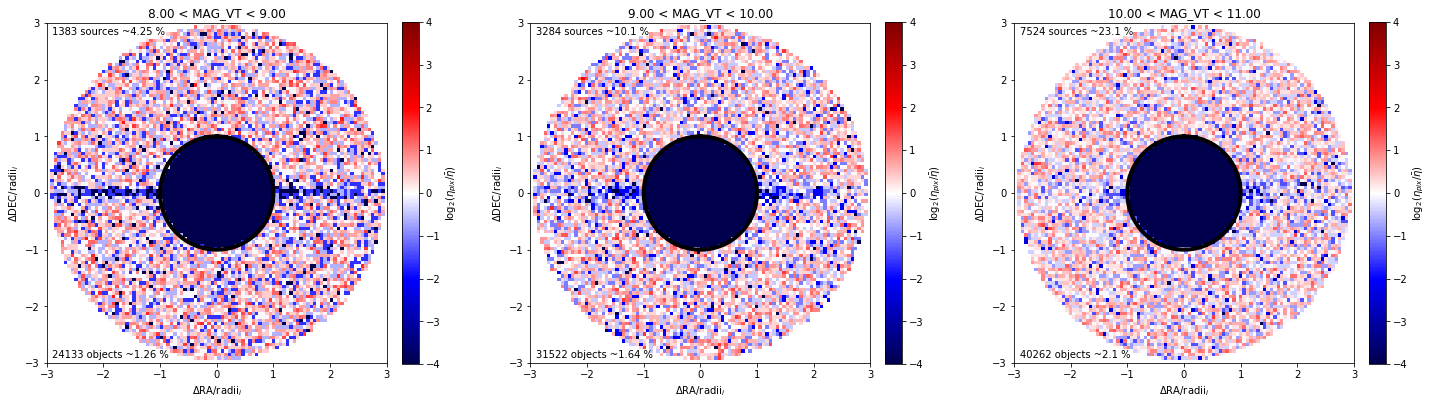

In [99]:
_ = overdensity(df[(bgs)], tycho, Dustin_MS_radii, 'MAG_VT', 35, density=False, 
                            magbins=(8,11,3), radii_2=None, grid=[1,3], SR=[1., 300.], scaling=True, nbins=101, 
                               SR_scaling=3,logDenRat=[-4, 4], radii_bestfit=False, annulus=None, eqbined=True,
                                   filename='%s/%s/2d_stacks_bgs_SR_300' %(dir_name, subdir))

9.00 < MAG_VT < 10.00
98898 nearby objects ~ 5.05684 %
mag_radii MAX: 72.39604267815174 mag_radii MIN: 53.458267411998776
mag MAX: 9.999 mag MIN: 9.001
d2d min=0.023, d2d max=5.61
1955727 1955727 1955727
152 of inf in density ratio out of a total of 7556
Minimum density ratio = -4, Maximum density ratio = 4.76544
----------------


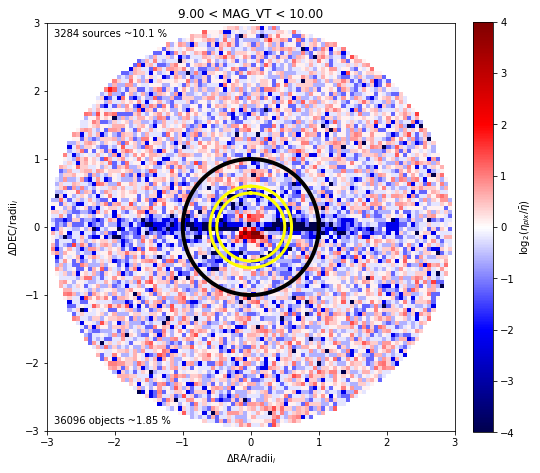

24
24 nearby objects ~ 0.000439948 %
Central coords in postage: RA:204.209960097163, DEC:4.047612021163, Cidx:2984408, rad:1.5
Central coords in postage: RA:166.264460132002, DEC:3.646220850691, Cidx:195449, rad:1.5
Central coords in postage: RA:185.540637649854, DEC:7.578257889289, Cidx:1768696, rad:1.5
Central coords in postage: RA:192.477025927689, DEC:-1.525250874137, Cidx:2160156, rad:1.5
Central coords in postage: RA:223.970811699637, DEC:13.671147791978, Cidx:5174306, rad:1.5


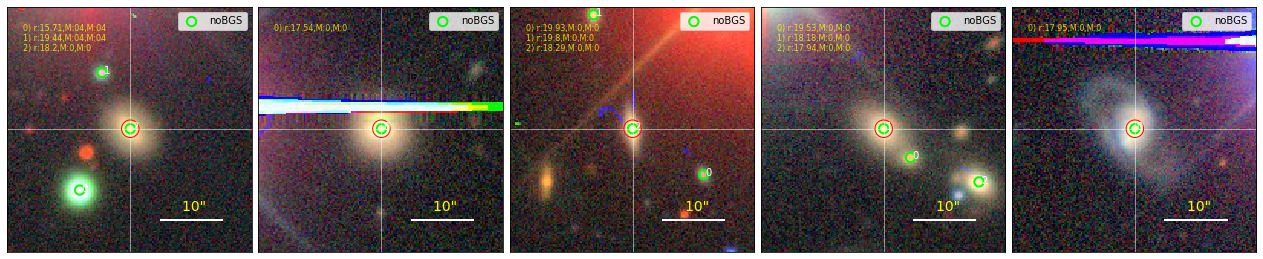

9.00 < MAG_VT < 10.00
98898 nearby objects ~ 5.05684 %
mag_radii MAX: 72.39604267815174 mag_radii MIN: 53.458267411998776
mag MAX: 9.999 mag MIN: 9.001
d2d min=0.023, d2d max=5.61
1955727 1955727 1955727
152 of inf in density ratio out of a total of 7556
Minimum density ratio = -4, Maximum density ratio = 4.76544
----------------


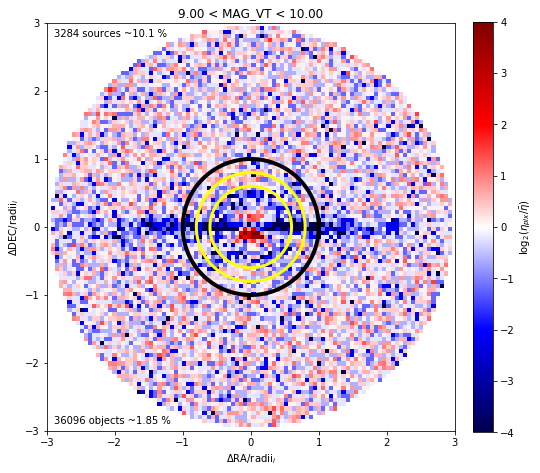

101
101 nearby objects ~ 0.00185145 %
Central coords in postage: RA:186.753669620631, DEC:8.976041952174, Cidx:1806502, rad:1.5
Central coords in postage: RA:171.830310182195, DEC:8.186049296386, Cidx:979946, rad:1.5
Central coords in postage: RA:225.092405496859, DEC:9.948974573243, Cidx:5054381, rad:1.5
Central coords in postage: RA:196.717864928423, DEC:-0.202487039202, Cidx:2153863, rad:1.5
Central coords in postage: RA:185.213742980796, DEC:-0.228744788109, Cidx:1439566, rad:1.5


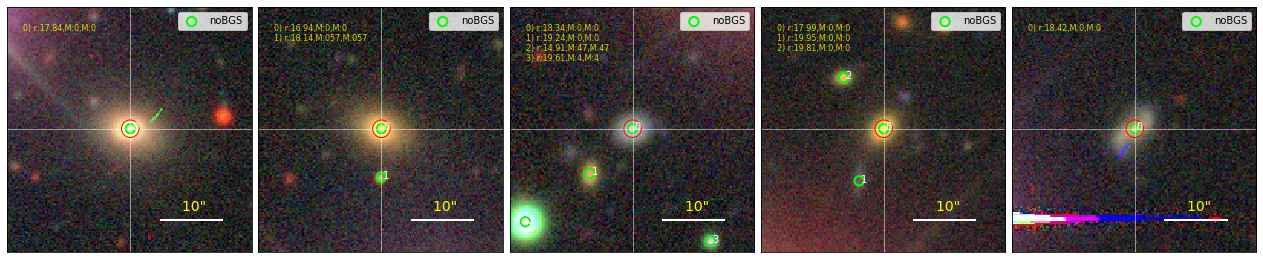

9.00 < MAG_VT < 10.00
98898 nearby objects ~ 5.05684 %
mag_radii MAX: 72.39604267815174 mag_radii MIN: 53.458267411998776
mag MAX: 9.999 mag MIN: 9.001
d2d min=0.023, d2d max=5.61
1955727 1955727 1955727
152 of inf in density ratio out of a total of 7556
Minimum density ratio = -4, Maximum density ratio = 4.76544
----------------


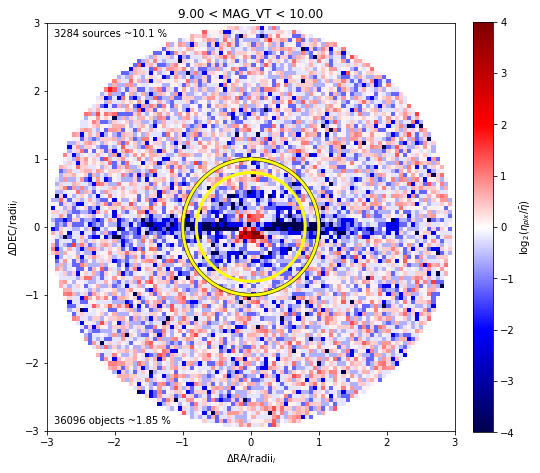

166
166 nearby objects ~ 0.00304298 %
Central coords in postage: RA:196.231005418157, DEC:16.094095438225, Cidx:2783122, rad:1.5
Central coords in postage: RA:175.513746974654, DEC:11.445654995038, Cidx:1121419, rad:1.5
Central coords in postage: RA:192.476983837632, DEC:-1.518291033834, Cidx:2160186, rad:1.5
Central coords in postage: RA:175.428954883542, DEC:5.187309650414, Cidx:963459, rad:1.5
Central coords in postage: RA:219.512339791564, DEC:3.579568642027, Cidx:3927105, rad:1.5


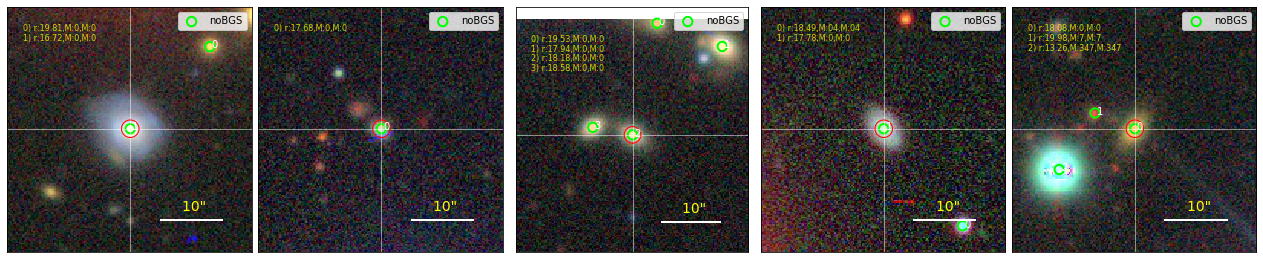

In [102]:
annbins = [0.5, 0.6, 0.8, 1]
for i in range(len(annbins)-1):
    
    #get objects within annulus in the 2D-stacks
    CATM = (bgs) | (BS_only)
    _,_, annM = overdensity(df[CATM], tycho, Dustin_MS_radii, 'MAG_VT', 35, density=False, 
                            magbins=(9,10,1), radii_2=None, grid=[1,1], SR=[1., 300.], scaling=True, nbins=101, 
                               SR_scaling=3,logDenRat=[-4, 4], radii_bestfit=False, annulus=[annbins[i],annbins[i+1]], eqbined=True,
                                   filename='%s/%s/2d_stacks_bgs_noBS_SR_300_annulus_%s_%s' 
                                        %(dir_name, subdir, str(annbins[i]),str(annbins[i+1])))
    plt.show()

    #Match objects in annulus with whole catalogue
    cat_maglim = rmag[CATM] < 18.5
    print(np.sum((annM) & (cat_maglim)))
    if cat_maglim is not None:
        idx2, idx1, d2d, d_ra, d_dec = search_around(df[CATM][(annM) & (cat_maglim)]['RA'], df[CATM][(annM) & (cat_maglim)]['DEC'], 
                                             df['RA'], df['DEC'], search_radius=0.1)
    else:
        idx2, idx1, d2d, d_ra, d_dec = search_around(df[CATM][annM]['RA'], df[CATM][annM]['DEC'], 
                                             df['RA'], df['DEC'], search_radius=0.1)

    #Get the postages...
    veto = {'noBGS':~bgs, 'BGS':bgs}
    info = {'r':rmag,'M':mask_lab, '':df['TYPE']}
    layer_dr7='decals-dr7'

    postages_circle(coord=[df['RA'], df['DEC']], centeridx=idx1, veto=veto, info=info, scale=0.262, 
                scale_unit='pixscale', layer=layer_dr7, radius=1.5/3600, m=14, grid=[1,5], 
                savefile='%s/%s/galaxies_within_annulus_%s_%s_9_MAGVT_10' %(dir_name, subdir, str(annbins[i]),str(annbins[i+1])), 
                    layer2=None, layer2Mode='separate', isLG=False)
    plt.show()

## LG mask with LSLGA -- Examples

416 nearby objects ~ 0.00762577 %
Central coords in postage: RA:205.113231945959, DEC:4.773825567022, Cidx:3030812, rad:25
Central coords in postage: RA:213.798955442287, DEC:15.742101990334, Cidx:4419998, rad:36
Central coords in postage: RA:186.887396639049, DEC:6.233351396668, Cidx:1801013, rad:19
Central coords in postage: RA:188.863449444913, DEC:12.750263109083, Cidx:1861071, rad:26
Central coords in postage: RA:190.081503335794, DEC:14.714919633241, Cidx:2596200, rad:37
Central coords in postage: RA:184.733836052834, DEC:8.961581488945, Cidx:1734765, rad:24
Central coords in postage: RA:203.542579794573, DEC:4.868478605197, Cidx:2964227, rad:31
Central coords in postage: RA:166.545447922181, DEC:4.336098166864, Cidx:197951, rad:45


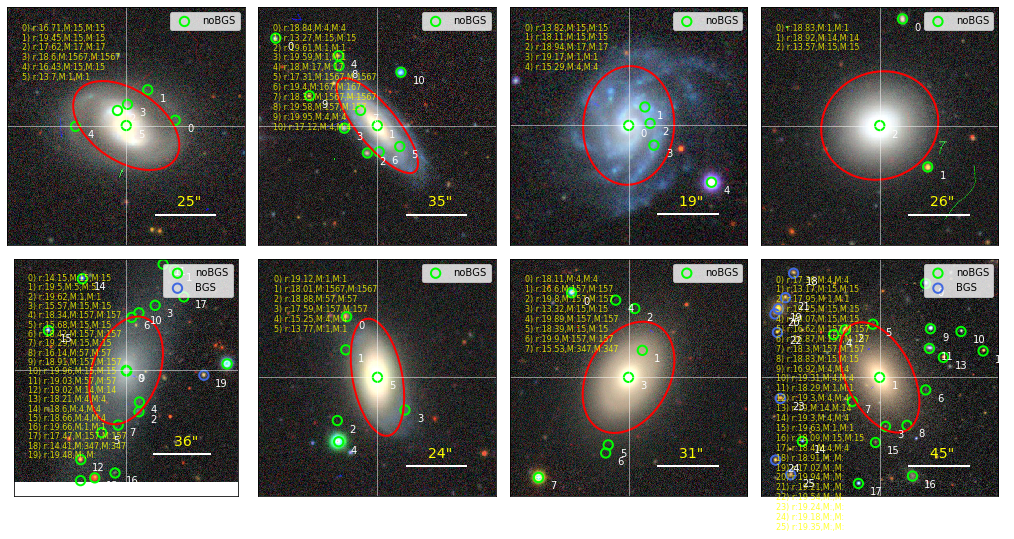

In [93]:
#get index of LSLGA in DECam
LGMagMASK = (LSLGA['MAG'] < 15) & (LSLGA['MAG'] > 14.5)
LG_idx1, radius_LG = inLSLGA(MASK=LGMagMASK)

#Get the postages...
veto = {'noBGS':~bgs, 'BGS':bgs}
info = {'r':rmag,'M':mask_lab, '':df['TYPE']}
layer_dr7='decals-dr7'
#if we want to compare the same objects with another catalogue (i.e., DR7, DR8) select only
#the right number of indexes as your grid to avoid the random selection in postages_circle.
postages_circle(coord=[df['RA'], df['DEC']], centeridx=LG_idx1[:8], veto=veto, info=info, scale=0.262, 
                scale_unit='pixscale', layer=layer_dr7, radius=radius_LG, m=2, grid=[2,4], 
                savefile='%s/%s/LSLGA_examples' %(dir_name, subdir), layer2=None, 
                layer2Mode='separate', isLG=True)

## BS mask with TYCHO2 -- Examples

2856 nearby objects ~ 0.0523539 %
Central coords in postage: RA:201.311083298291, DEC:0.852094323561, Cidx:3050439, rad:39
Central coords in postage: RA:166.356142610596, DEC:3.670747536381, Cidx:195473, rad:38
Central coords in postage: RA:194.092694584415, DEC:4.092329438241, Cidx:2219368, rad:35
Central coords in postage: RA:167.700058466270, DEC:5.721042562197, Cidx:390451, rad:39
Central coords in postage: RA:192.188369730000, DEC:5.654596420000, Cidx:2501066, rad:36
Central coords in postage: RA:165.402136043325, DEC:0.104037426908, Cidx:159604, rad:36
Central coords in postage: RA:166.785589698489, DEC:0.149731565838, Cidx:198280, rad:35
Central coords in postage: RA:168.368361004548, DEC:1.996784071482, Cidx:232554, rad:36


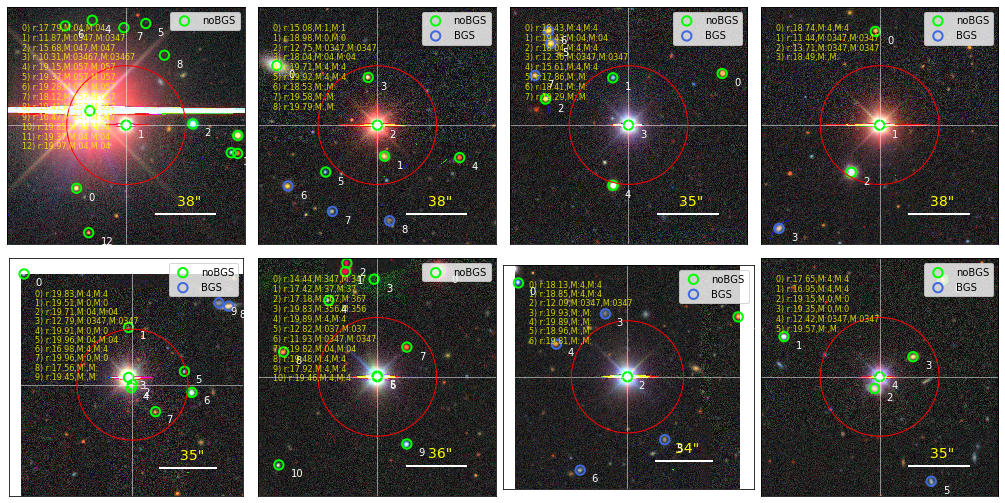

In [94]:
TyMagMask = (tycho['MAG_VT'] < 11.5) & (tycho['MAG_VT'] > 11.)
Tyidx1, Ty_kyle_rad, Ty_dustin_rad = inTycho2(MASK=TyMagMask)

#Get the postages...
veto = {'noBGS':~bgs, 'BGS':bgs}
info = {'r':rmag,'M':mask_lab, '':df['TYPE']}
layer_dr7='decals-dr7'
#if we want to compare the same objects with another catalogue (i.e., DR7, DR8) select only
#the right number of indexes as your grid to avoid the random selection in postages_circle.
postages_circle(coord=[df['RA'], df['DEC']], centeridx=Tyidx1[:8], veto=veto, info=info, scale=0.262, 
                scale_unit='pixscale', layer=layer_dr7, radius=Ty_dustin_rad/3600., m=2, grid=[2,4], 
                savefile='%s/%s/BS_examples' %(dir_name, subdir), layer2=None, 
                layer2Mode='separate', isLG=False)

## GAIA objects in BGS...

In [59]:
def get_3sigma(DF, sigma):
    
    mean = np.mean(DF)
    sd = np.std(DF)
    print('mean',mean)
    
    MASK = np.logical_and(DF > mean - sigma * sd, DF < mean + sigma * sd)
    MASK1 = np.logical_and(DF > mean - 1 * sd, DF < mean + 1 * sd)
    MASK2 = np.logical_and(DF > mean - 2 * sd, DF < mean + 2 * sd)

    print('mean=%2.3g, sd=%2.3g' %(mean, sd))
    print('%2.5g %% at 1-sigma level' %(len(DF[MASK1])*100/len(DF)))
    print('%2.5g %% at 2-sigma level' %(len(DF[MASK2])*100/len(DF)))
    print('%2.5g %% at %2.2g-sigma level' %(len(DF[MASK])*100/len(DF), sigma))
    
    return DF[MASK], mean, sd, len(DF[MASK1])*100/len(DF), len(DF[MASK2])*100/len(DF), len(DF[MASK])*100/len(DF)

def gr_rz_density(cat1, title, fixed=False, otherCat=False, MASK=None, MASKname=None,log=False, savefile=None, plot='scatter', 
                  plotPars='Grr'):
    
    rmag = flux_to_mag(cat1['FLUX_R']/cat1['MW_TRANSMISSION_R'])
    gmag = flux_to_mag(cat1['FLUX_G']/cat1['MW_TRANSMISSION_G'])
    zmag = flux_to_mag(cat1['FLUX_Z']/cat1['MW_TRANSMISSION_Z'])
    gaiagmag = cat1['GAIA_PHOT_G_MEAN_MAG']
    Grr = gaiagmag - 22.5 + 2.5*np.log10(cat1['FLUX_R'])
    
    mask = (~np.isnan(gmag)) & (~np.isnan(zmag)) & (~np.isinf(gmag)) & (~np.isinf(zmag))
    #mask &= (gmag-zmag > -2) & (gmag-zmag < 5) & (Grr > -2) & (Grr < 4)
    #mask &= (gaiagmag != 0)
    rmag = rmag[mask]
    gmag = gmag[mask]
    zmag = zmag[mask]
    gaiagmag = gaiagmag[mask]
    Grr = Grr[mask]
    TYPE = cat1['TYPE'][mask]
    
    if plotPars == 'Grr':
        x = gmag-zmag
        y = Grr
    if plotPars == 'gr-rz':
        x = gmag-rmag
        y = rmag-zmag
        
    STARS = Grr < 0.6
    GAL = Grr > 0.6
    PSF = TYPE == 'PSF '
    noPSF = TYPE != 'PSF '
    
    fig = plt.figure(figsize=(10, 8))
    
    left, width = 0.1, 0.85
    bottom, height = 0.1, 0.85

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom, width, 0.3]
    rect_histy = [left, bottom, 0.3, height]
    colbar = [1.1, 0.1, 0.1, 0.85]

    axScatter = plt.axes(rect_scatter)
    axScatter.set_title(title, size=15)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)
    
    if plot == 'hexbin':
        if log:
            bins='log'
        else:
            bins=None
            
        pos = axScatter.hexbin(x, y, gridsize=(60,60), cmap='viridis', bins=bins, 
                           mincnt=1,label=r'test', alpha=0.8)
    if plot == 'scatter':
        axScatter.scatter(x[PSF], y[PSF], s=0.07, color='gray', alpha=0.8, label='GAIA PSF')
        axScatter.scatter(x[noPSF], y[noPSF], s=0.07, color='orange', alpha=0.8, label='GAIA noPSF')
    
    #MASK
    if MASK is not None:
        #print(len(MASK), len(mask))
        MASK2 = MASK[mask]
        
        axScatter.scatter(x[MASK2], y[MASK2], s=0.4, color='red', label='%s, f(%%)=%2.3g' %(MASKname, 100*np.sum(MASK)/np.sum(bgs)))
        print('fraction of %s out of total BGS (%2.3g): %2.3g' %(MASKname, np.sum(bgs), 100*np.sum(MASK)/np.sum(bgs)))
        
    cbaxes = fig.add_axes([1, 0.1, 0.03, 0.8])
    if plot == 'hexbin':
        if log:
            fig.colorbar(pos, cax=cbaxes, label=r'$\log_{10}(N)$')
        else:
            fig.colorbar(pos, cax=cbaxes, label=r'$N$')
    
    if plotPars == 'gr-rz':
        axScatter.set_ylabel(r'$r-z$', size=15)
        axScatter.set_xlabel(r'$g-r$',size=15)
    
    if plotPars == 'Grr':
        axScatter.set_ylabel(r'$G - 22.5 + 2.5\times \log_{10}$(FLUX_R)', size=15)
        axScatter.set_xlabel(r'$2.5\times \log_{10}$(FLUX_Z$\times$ MW_TRANSMISSION_G/FLUX_G$\times$ MW_TRANSMISSION_Z)',size=12)
    
    axScatter.grid()
    #axScatter.legend()
    
    binsy = np.linspace(y.min(), y.max(), 50)
    binsx = np.linspace(x.min(), x.max(), 50)
    
    N1 = axHistx.hist(x, bins=binsx, cumulative=False, histtype='step', align='mid', color='k', linewidth=2, log=log)
    N2 = axHisty.hist(y, bins=binsy, cumulative=False, histtype='step', align='mid', 
                      color='k', linewidth=2, log=log, orientation='horizontal')
    #N3 = axHisty.hist(y[noPSF], bins=binsy, cumulative=False, histtype='step', align='mid', 
    #                  color='orange', linewidth=2, log=log, orientation='horizontal')
    
    if MASK is not None:
        N4 = axHistx.hist(x[MASK2], bins=binsx, cumulative=False, histtype='step', align='mid', color='r', linewidth=2, log=log)
        N5 = axHisty.hist(y[MASK2], bins=binsy, cumulative=False, histtype='step', align='mid', 
                      color='r', linewidth=2, log=log, orientation='horizontal')

    if len(y[TYPE != 'PSF ']) != 0:
        print('stats for non-PSF')
        cattemp, mean, sd, sig_1, sig_2, sig_3 = get_3sigma(y[TYPE != 'PSF '], 3)
        #axScatter.axhline(mean+3*sd, linestyle='--', color='red')
        #axScatter.axhline(mean-3*sd, linestyle='--', color='red')
    if len(y[TYPE == 'PSF ']) != 0:
        print('stats for PSF')
        cattemp2, mean2, sd2, sig_12, sig_22, sig_32 = get_3sigma(y[TYPE == 'PSF '], 3)
        #axScatter.axhline(mean2+3*sd2, linestyle='--', color='orange')
        #axScatter.axhline(mean2-3*sd2, linestyle='--', color='orange')
    
    if plotPars == 'Grr':
        axScatter.axhline(0.6, linestyle='--', lw=2, color='k')
        
    if fixed:
        axScatter.set_xlim(-1, 3)
        axScatter.set_ylim(-1, 3)
    
    axHistx.axis('off')
    axHisty.axis('off')
    
    if plot == 'scatter':
        lgnd = axScatter.legend()
        for handle in lgnd.legendHandles:
            handle.set_sizes([14.0])
    
    fig.subplots_adjust(wspace=0.05, hspace=0.4, right=1.1)
    
    if savefile != None:
        fig.savefig(savefile +'.png') #bbox_inches = 'tight', pad_inches = 0


stats for non-PSF
mean 1.7387259
mean=1.74, sd=0.562
72.562 % at 1-sigma level
95.442 % at 2-sigma level
98.453 % at  3-sigma level
stats for PSF
mean 0.025820395
mean=0.0258, sd=0.216
86.285 % at 1-sigma level
95.62 % at 2-sigma level
98.329 % at  3-sigma level


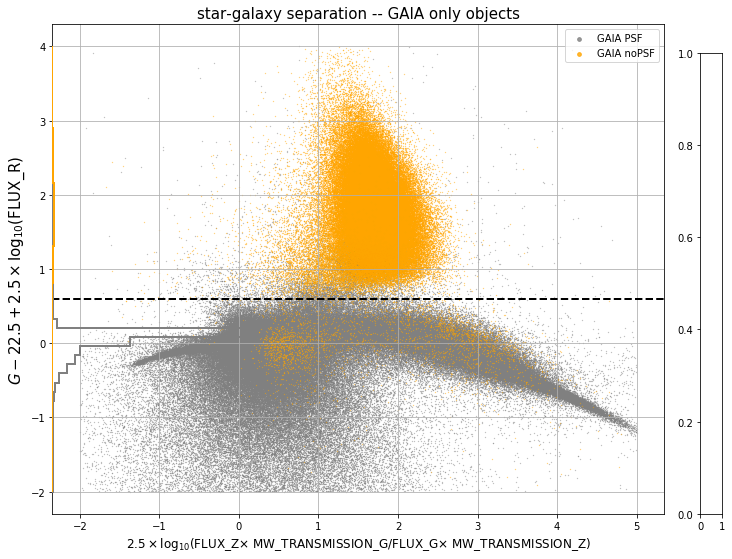

In [68]:
gaia = df['GAIA_PHOT_G_MEAN_MAG'] != 0
#MASK = (gaia) & (bgs)
MASK = None
#MASKname ='GAIAinBGS'
MASKname = None

gr_rz_density(df, 'star-galaxy separation -- GAIA only objects', fixed=False, otherCat=False, 
              MASK=MASK, MASKname=MASKname, log=False, savefile=None)

stats for non-PSF
mean 1.775873
mean=1.78, sd=0.49
67.256 % at 1-sigma level
96.141 % at 2-sigma level
99.64 % at  3-sigma level
stats for PSF
mean 0.7409663
mean=0.741, sd=0.132
81.453 % at 1-sigma level
95.865 % at 2-sigma level
98.073 % at  3-sigma level


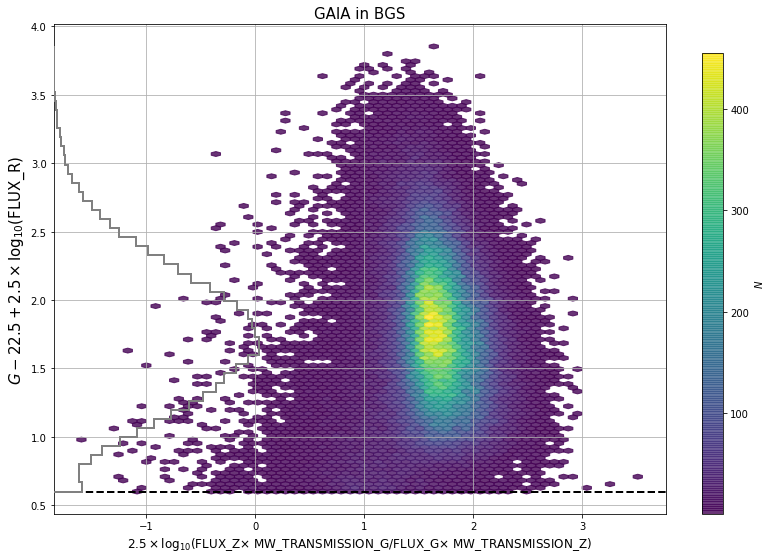

In [78]:
gr_rz_density(df[(gaia) & (bgs)], 'GAIA in BGS', fixed=False, otherCat=False, 
              MASK=None, MASKname=None, log=False, savefile=None, plot='hexbin')

fraction of GAIAinBGS out of total BGS (1.9e+06): 7.5
stats for non-PSF
mean 0.6358446
mean=0.636, sd=0.211
68.39 % at 1-sigma level
95.691 % at 2-sigma level
99.632 % at  3-sigma level
stats for PSF
mean 0.7081421
mean=0.708, sd=0.608
72.143 % at 1-sigma level
94.49 % at 2-sigma level
99.694 % at  3-sigma level


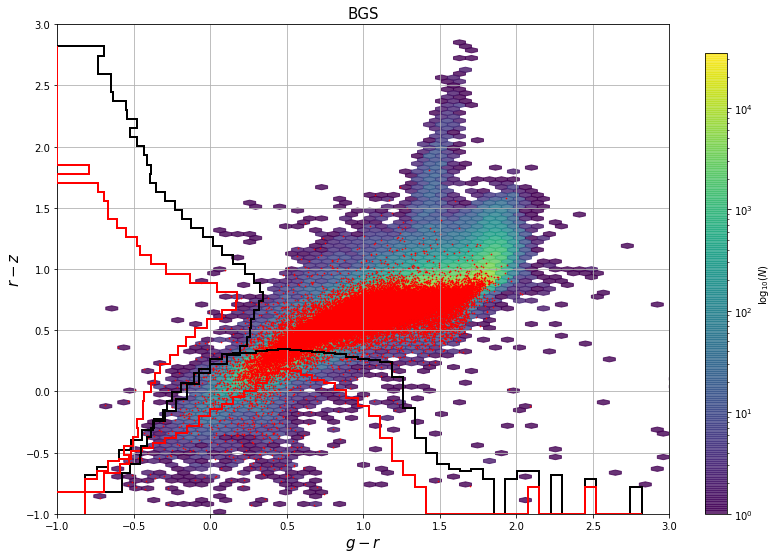

In [92]:
gr_rz_density(df[(bgs)], 'BGS', fixed=True, otherCat=False, 
              MASK=gaia[bgs], MASKname='GAIAinBGS', log=True, savefile=None, plot='hexbin', plotPars='gr-rz')

In [94]:
dustin_rad[idx1] = circular_mask_radii_func(tycho['MAG_VT'][MASK][idx2], Dustin_MS_radii, bestfit=False)

array([     20,      91,     391, ..., 5157604, 5157640, 5157663])

3651
Central coords in postage: RA:165.791843479822, DEC:-1.404124178874, Cidx:20547, rad:1.5
Central coords in postage: RA:223.806909198742, DEC:16.458735440752, Cidx:5036532, rad:1.5
Central coords in postage: RA:164.813773456929, DEC:16.266757947837, Cidx:640866, rad:1.5
Central coords in postage: RA:195.409371446811, DEC:4.229766637270, Cidx:2064302, rad:1.5
Central coords in postage: RA:182.694848190384, DEC:10.842086541896, Cidx:1887167, rad:1.5


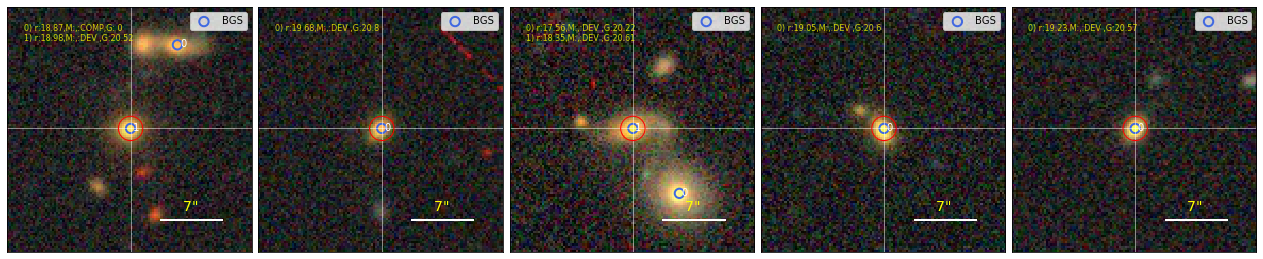

In [119]:
#Get the postages...
veto = {'noBGS':~bgs, 'BGS':bgs}
info = {'r':rmag,'M':mask_lab, '':df['TYPE'], 'G':df['GAIA_PHOT_G_MEAN_MAG']}
layer_dr7='decals-dr7'
#'%s/%s/BGSinGAIA_1.5_gr-rz_2' %(dir_name, subdir)

inGaiaidx = np.where((bgs) & (gaia) & (gmag-rmag > 1.5) & (gmag-rmag < 2.0))[0]
#gaia_radii = circular_mask_radii_func(df['GAIA_PHOT_G_MEAN_MAG'], Dustin_MS_radii, bestfit=False)
print(len(inGaiaidx))

#if we want to compare the same objects with another catalogue (i.e., DR7, DR8) select only
#the right number of indexes as your grid to avoid the random selection in postages_circle.
postages_circle(coord=[df['RA'], df['DEC']], centeridx=inGaiaidx, veto=veto, info=info, scale=0.262, 
                scale_unit='pixscale', layer=layer_dr7, radius=1.5/3600., m=10, grid=[1,5], 
                savefile=None, layer2=None, 
                layer2Mode='separate', isLG=False)

### Writte cat to fits

In [122]:
from astropy.table import Table

GAIAinBGS = Table()
colnames = ['RA', 'DEC']
for i in colnames:
    GAIAinBGS[i] = df[i][(bgs) & (gaia)]
        
GAIAinBGS_cat_path = '%s/%s/GAIAinBGS_cat' %(dir_name, subdir)
#np.save(GAIAinBGS_cat_path, GAIAinBGS)
GAIAinBGS.write(GAIAinBGS_cat_path+'.fits', overwrite=True)

In [52]:
def rmag_fibmag_density(cat1, title, otherCat=False, MASK=None, Cpar=None, CparName=None, log=False, fmc=False):
    
    rmag = flux_to_mag(cat1['FLUX_R']/cat1['MW_TRANSMISSION_R'])
    gmag = flux_to_mag(cat1['FLUX_G']/cat1['MW_TRANSMISSION_G'])
    zmag = flux_to_mag(cat1['FLUX_Z']/cat1['MW_TRANSMISSION_Z'])
    fibmag = flux_to_mag(cat1['FIBERFLUX_R']/cat1['MW_TRANSMISSION_R'])
    
    mask = (~np.isnan(gmag)) & (~np.isnan(zmag)) & (~np.isinf(gmag)) & (~np.isinf(zmag))
    rmag = rmag[mask]
    gmag = gmag[mask]
    zmag = zmag[mask]
    fibmag = fibmag[mask]
    
    fig = plt.figure(figsize=(6, 6))
    
    left, width = 0.1, 0.85
    bottom, height = 0.1, 0.85

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom, width, 0.3]
    rect_histy = [left, bottom, 0.3, height]
    colbar = [1.1, 0.1, 0.1, 0.85]

    axScatter = plt.axes(rect_scatter)
    axScatter.set_title(title)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)
    
    x = rmag
    y = fibmag
    
    if log:
        bins1 = 'log'
    else:
        bins1 = None
        
    pos = axScatter.hexbin(x, y, C=Cpar, gridsize=(60,60), cmap='viridis', bins=bins1, 
                           mincnt=1,label=r'test', alpha=0.8)
    
    if fmc:
        #New FMC cut
        x_N1 = np.linspace(15.5, 17.1, 4)
        axScatter.plot(x_N1, 2.9 + 1.2 + x_N1, color='k', ls='--', lw=2)
        x_N2 = np.linspace(17.1, 18.3, 4)
        axScatter.plot(x_N2, x_N2*0.+21.2, color='k', ls='--', lw=2)
        x_N3 = np.linspace(18.3, 20.1, 4)
        axScatter.plot(x_N3, 2.9 + x_N3, color='k', ls='--', lw=2)
 
    cbaxes = fig.add_axes([1, 0.1, 0.03, 0.8])
    
    if Cpar is None:
        CparName = 'N'
        
    if log:
        fig.colorbar(pos, cax=cbaxes, label=r'$\log_{10}(%s)$' %(CparName))
    else:
        fig.colorbar(pos, cax=cbaxes, label=r'$%s$' %(CparName))
        
    axScatter.set_xlabel(r'r-mag', size=18)
    axScatter.set_ylabel(r'r-fibmag', size=18)
    axScatter.grid()
    
    binsy = np.linspace(y.min(), y.max(), 50)
    binsx = np.linspace(x.min(), x.max(), 50)
    
    N1 = axHistx.hist(x, bins=binsx, cumulative=False, log=False, histtype='step', align='mid', color='r', linewidth=2)
    N2 = axHisty.hist(y, bins=binsy, cumulative=False, log=False, histtype='step', align='mid', color='r', linewidth=2, orientation='horizontal')
    
    axHistx.axis('off')
    axHisty.axis('off')
   

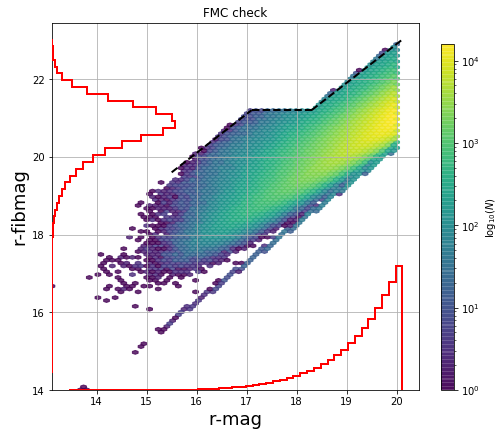

In [53]:
rmag_fibmag_density(df[bgs], 'FMC check', otherCat=False, MASK=None, Cpar=None, CparName=None, log=True, fmc=True)

## Venn diagrams

plt.figure(figsize=(8,4))
plt.scatter(rmag[FMC][::10], fibmag[FMC][::10], s=0.6, color='blue', label='FMC')
plt.scatter(rmag[~FMC][::10], fibmag[~FMC][::10], s=0.6, color='red', label='~FMC')
x = np.linspace(12, 20, 30)
y = 3.0 + 1.0*x
plt.plot(x, y, lw=2, c='k', label='Fibre Mag cut')
plt.legend()
plt.xlabel('rmag')
plt.ylabel('fibmag')
plt.xlim(12, 20)
plt.ylim(12.5, 27.5)
plt.show()

# MORE DEFINITIONS

## allmask Vs fracs* overlap in all stages...

In [48]:
def venn_stage(M, Mlab, A, PM=None, title=None, filename=None):
    
    from matplotlib_venn import venn2
    
    if PM is not None:
        a = (M[0]) & (~PM)
        b = (M[1]) & (~PM)
        c = (a) & (b)
    else:
        a = M[0]
        b = M[1]
        c = (a) & (b)
    
    sf = 2
    a1 = round((np.sum(a) - np.sum(c))/A, sf)
    b1 = round((np.sum(b) - np.sum(c))/A, sf)
    c1 = round(np.sum(c)/A, sf)

    plt.figure(figsize=(5, 5))
    plt.title('%s=%s' %('PM', title))
    venn2([a1, b1, c1], set_labels = (Mlab[0], Mlab[1]))
    
    if filename is not None:
            plt.savefig(filename+'.png')
    
    return np.sum(a)/A, np.sum(b)/A, np.sum(c)/A, a1, b1
    

In [49]:
def venn_stages(M, Mlab, A, PM, title, dir_name):
    data = []

    for i in range(len(stages)):
    
        a, b, c, a1, b1 = venn_stage(M=M, Mlab=Mlab, A=A, PM=(PM[i]), 
           title=title[i], filename='%s/venn_%s_%s_%s' %(dir_name, Mlab[0], Mlab[1], title[i]))
    
        data.append([title[i], a, b, c, a1, b1])
        
    data2 = []
    for i in range(len(data[0])):
        if len(data) == 6:
            data2.append([data[0][i], data[1][i], data[2][i], data[3][i] , data[4][i] , data[5][i]])
        if len(data) == 7:
            data2.append([data[0][i], data[1][i], data[2][i], data[3][i] , data[4][i] , data[5][i], data[6][i]])

    plt.figure(figsize=(10,5))
    plt.plot(data2[0], data2[1], marker='o', lw=2, c='b',label=Mlab[0])
    plt.xticks(rotation=45)
    plt.plot(data2[0], data2[2], marker='o', lw=2, c='k', label=Mlab[1])
    plt.plot(data2[0], data2[3], marker='o', lw=2, ls=r'--', c='brown', label='%s & %s' %(Mlab[0], Mlab[1]))
    plt.plot(data2[0], data2[4], marker='o', lw=2, ls=r'--', c='pink', label='%s & ~%s' %(Mlab[0], Mlab[1]))
    plt.plot(data2[0], data2[5], marker='o', lw=2, ls=r'--', c='green', label='~%s & %s' %(Mlab[0], Mlab[1]))

    plt.legend()
    plt.grid()
    plt.xlabel(r'PREVIOUS MASKING (PM)')
    plt.ylabel(r'1/deg$^2$')
    plt.savefig('%s/mask_density_%s_%s.png' %(dir_name, Mlab[0], Mlab[1]))
    plt.show()


In [3]:
stages = [None, (GM[0] | GM[1]), (GM[0] | GM[1] | allmask), (GM[0] | GM[1] | allmask| nobs), (GM[0] | GM[1] | allmask | nobs | STARS),
             (GM[0] | GM[1] | allmask | nobs | STARS | ~CC)]
stages_lab = ['None', 'GM', 'GM+ALLMASK', 'GM+ALLMASK+NOBS', 'GM+ALLMASK+NOBS+STARS', 'GM+ALLMASK+NOBS+STARS+CC']
M = [~FMC, ~QC]
Mlab=['FMC', 'fracs*']
venn_stages(M=M, Mlab=Mlab, A=A, PM=stages, title=stages_lab, dir_name=dir_name+'/'+subdir)

NameError: name 'GM' is not defined

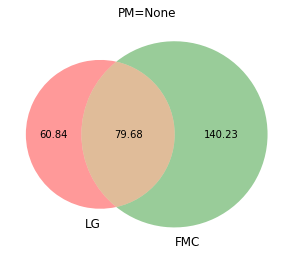

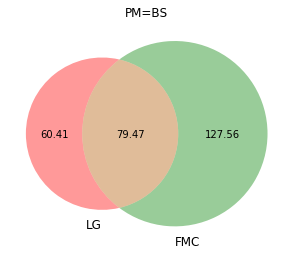

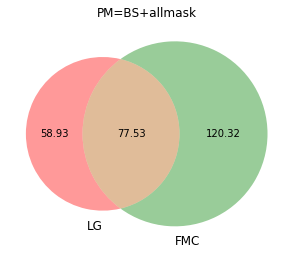

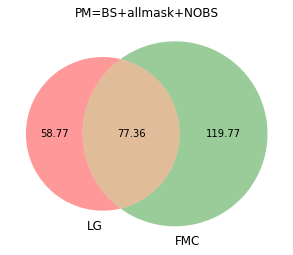

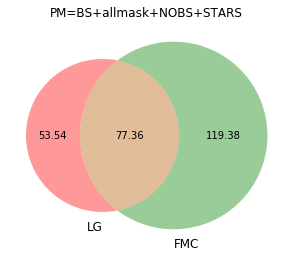

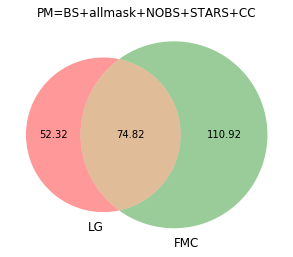

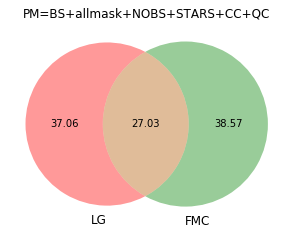

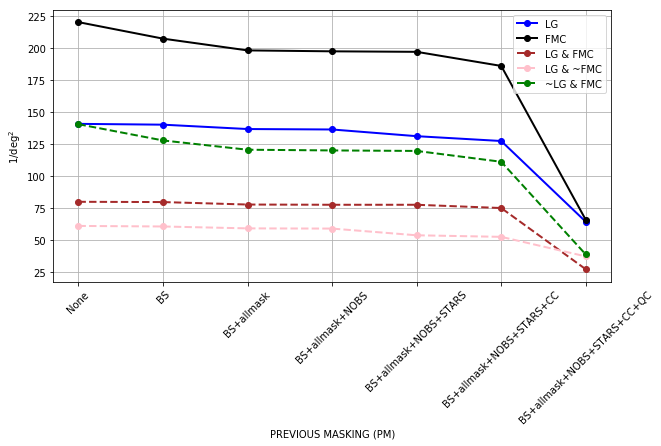

In [47]:
stages = [None, (GM[0]), (GM[0] | allmask ), (GM[0] | allmask | nobs), 
          (GM[0] | allmask | nobs | STARS), (GM[0] | allmask | nobs | STARS | ~CC), 
          (GM[0] | allmask | nobs | STARS | ~CC | ~QC)]
stages_lab = ['None', 'BS', 'BS+allmask', 'BS+allmask+NOBS', 'BS+allmask+NOBS+STARS', 
              'BS+allmask+NOBS+STARS+CC', 'BS+allmask+NOBS+STARS+CC+QC']

M = [GM[1], ~FMC]
Mlab=['LG', 'FMC']
venn_stages(M=M, Mlab=Mlab, A=A, PM=stages, title=stages_lab, dir_name=dir_name+'/'+subdir)

In [52]:
np.sum((GM[0]) & (GM[1]) & (STARS))

14

## Save BGS catalogue...

In [52]:
from astropy.table import Table

BGS = Table()
BGS_colnames = ['RA', 'DEC', 'TYPE', 'FLUX_R', 'FLUX_G', 'FLUX_Z', 'MW_TRANSMISSION_R', 'MW_TRANSMISSION_G', 
                'MW_TRANSMISSION_Z', 'GAIA_PHOT_G_MEAN_MAG', 'GAIA_DUPLICATED_SOURCE', 'FIBERFLUX_R', 'BRIGHTSTARINBLOB', 'CUTS']
for i in BGS_colnames:
    if i is 'CUTS':
        BGS[i] = mask_lab
    else:
        BGS[i] = df[i]
        
BGS_cat_path = '%s/%s/BGS_cat' %(dir_name, subdir)
np.save(BGS_cat_path, BGS)

## Save Randoms catalogue...

In [53]:
from astropy.table import Table

randoms = Table()
randoms_colnames = ['RA', 'DEC', 'CUTS']
for i in randoms_colnames:
    if i is 'CUTS':
        randoms[i] = mask_lab_ran
    else:
        randoms[i] = df_ran[i]
        
randoms_cat_path = '%s/%s/randoms_cat' %(dir_name, subdir)
np.save(randoms_cat_path, randoms)

### define 2D stacks images function...

In [50]:
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.gridspec as gridspec

def overdensity(cat, star, radii_1, nameMag, slitw, density=False, magbins=(8,14,4), radii_2=None, 
                grid=None, SR=[2, 240.], scaling=False, nbins=101, SR_scaling=4, logDenRat=[-3, 3], 
                    radii_bestfit=True, annulus=None, eqbined=False, filename=None):
    '''
    Get scatter and density plots of objects of cat1 around objects of cat2 within a search radius in arcsec.

    Inputs
    ------
    cat: (array) catalogue 1;
    star: (array) catalogue 2;
    nameMag: (string) label of magnitude in catalogue 2;
    slitw: (float, integer) slit widht;
    density: (boolean) True to get the density as function of distance (arcsec) within shells;
    magbins: (integers) format to separate the magnitude bins in cat2 (min, max, number bins);

    Output
    ------
    (distance (arcsec), density) if density=True
    '''
    # define the slit width for estimating the overdensity off diffraction spikes
    slit_width = slitw
    search_radius = SR[1]

    # Paramater for estimating the overdensities
    annulus_min = SR[0]
    annulus_max = SR[1]

    ra2 = star['RA']
    dec2 = star['DEC']
    
    ra1 = cat['RA']
    dec1 = cat['DEC']

    if density:

        idx2, idx1, d2d, d_ra, d_dec = search_around(ra2, dec2, ra1, dec1,
                                                 search_radius=search_radius)
        density = []
        shells = np.linspace(1, search_radius, search_radius)
        for i in range(len(shells)-1):

            ntot_annulus = np.sum((d2d>shells[i]) & (d2d<shells[i+1]))
            density_annulus = ntot_annulus/(np.pi*(shells[i+1]**2 - shells[i]**2))
            bincenter = (shells[i]+shells[i+1])/2

            density.append([bincenter, density_annulus])

        density = np.array(density).transpose()
        plt.figure(figsize=(12, 8))
        plt.semilogy(density[0], density[1])
        plt.xlabel(r'r(arcsec)')
        plt.ylabel(r'N/($\pi r^2$)')
        plt.grid()
        plt.show()

        return density


    if eqbined:
        mag_bins = np.linspace(magbins[0], magbins[1], magbins[2]+1)
        mag_bins_len = len(mag_bins)-1
    else:
        mag_bins = np.linspace(magbins[0], magbins[1], magbins[2])
        mag_bins_len = len(mag_bins)
    
    
    if grid is not None:
        rows, cols = grid[0], grid[1]
    else:
        rows, cols = len(mag_bins), 1
    figsize = (8*cols, 8*rows)
    gs = gridspec.GridSpec(rows, cols)
    gs.update(wspace=0.3, hspace=0.2)
    fig = plt.figure(num=1, figsize=figsize)
    ax = []
        
    for index in range(mag_bins_len):
        if eqbined:
            mask_star = (star[nameMag]>mag_bins[index]) & (star[nameMag]<mag_bins[index+1])
            title = '{:.2f} < {} < {:.2f}'.format(mag_bins[index], nameMag, mag_bins[index+1], np.sum(mask_star))    
        else:
            if index==0:
                mask_star = (star[nameMag]<mag_bins[index])
                title = '{} < {:.2f}'.format(nameMag,mag_bins[0], np.sum(mask_star))
            else:
                mask_star = (star[nameMag]>mag_bins[index-1]) & (star[nameMag]<mag_bins[index])
                title = '{:.2f} < {} < {:.2f}'.format(mag_bins[index-1], nameMag, mag_bins[index], np.sum(mask_star))

        print(title)

        if not scaling:
            #get the mask radii from the mean magnitude
            mag_mean = np.mean(star[nameMag][mask_star])
            print('mag_mean', mag_mean)
            mask_radius = circular_mask_radii_func([mag_mean], radii_1, bestfit=radii_bestfit)[0]
            if radii_2:
                mask_radius2 = circular_mask_radii_func([mag_mean], radii_2)[0]

        idx2, idx1, d2d, d_ra, d_dec = search_around(ra2[mask_star], dec2[mask_star], ra1, dec1,
                                                 search_radius=annulus_max)

        Nsources = len(ra2[mask_star])
        perc_sources = 100*len(ra2[mask_star])/len(ra2)
        
        #print('%d sources ~%g %% ' %(Nsources, perc_sources))
        
        mag_radii = circular_mask_radii_func(star[nameMag][mask_star][idx2], radii_1, bestfit=radii_bestfit)
        #print(len(d_ra), len(mag_radii))
        print('mag_radii MAX:',mag_radii.max(), 'mag_radii MIN:',mag_radii.min())
        print('mag MAX:',star[nameMag][mask_star][idx2].max(), 'mag MIN:',star[nameMag][mask_star][idx2].min())

        #markersize = np.max([0.01, np.min([10, 0.3*100000/len(idx2)])])
        #axis = [-search_radius*1.05, search_radius*1.05, -search_radius*1.05, search_radius*1.05]
        #axScatter = scatter_plot(d_ra, d_dec, markersize=markersize, alpha=0.4, figsize=6.5, axis=axis, title=title)
        
        row = (index // cols)
        col = index % cols
        ax.append(fig.add_subplot(gs[row, col]))
        
        if scaling:
            d2d_arcsec = d2d
            d_ra, d_dec, d2d = d_ra/mag_radii, d_dec/mag_radii, d2d_arcsec/mag_radii
            search_radius = SR_scaling #d2d.max() - d2d.max()*0.3
            #ntot_annulus = np.sum((d2d_arcsec>annulus_min) & (d2d<search_radius))
            ntot_annulus = np.sum(d2d<search_radius)
            #density_annulus = ntot_annulus/(np.pi*(search_radius**2 - d2d[d2d_arcsec > 2].min()**2))
            density_annulus = ntot_annulus/(np.pi*(search_radius**2))
            #print('ntot_annulus:', ntot_annulus, 'density_annulus:', density_annulus)
            print('d2d min=%2.3g, d2d max=%2.3g' %(d2d.min(), d2d.max()))
        else:
            d2d_arcsec = None
            ntot_annulus = np.sum((d2d>annulus_min) & (d2d<annulus_max))
            density_annulus = ntot_annulus/(np.pi*(annulus_max**2 - annulus_min**2))
        
        if annulus is not None:
            annMask = np.ones(len(cat), dtype='?')
            d_ra2 = np.zeros(len(cat))
            d_dec2 = np.zeros(len(cat))
            d_ra2[idx1] = d_ra
            d_dec2[idx1] = d_dec
            print(len(cat), len(d_ra2), len(d_dec2))
            #print(len(set(idx1)), len(set(idx2)))
            #print(idx1.max(), idx2.max())
            #angle_array = np.linspace(0, 2*np.pi, 240)
            annMask &= np.logical_and((d_ra2**2 + d_dec2**2) < annulus[1]**2, (d_ra2**2 + d_dec2**2) > annulus[0]**2)
            
            #annMask &= np.logical_and(d_dec < annulus[1] * np.cos(angle_array), d_dec > annulus[0] * np.cos(angle_array))
        
        bins, mesh_d2d, density_ratio = relative_density_plot(d_ra, d_dec, d2d, search_radius,
                        ref_density=density_annulus, return_res=True,
                            show=False, nbins=nbins, ax=ax[-1], d2d_arcsec=d2d_arcsec, annulus_min=annulus_min, logDenRat=logDenRat)
   
        if not scaling:
            angle_array = np.linspace(0, 2*np.pi, 240)
            x = mask_radius * np.sin(angle_array)
            y = mask_radius* np.cos(angle_array)
            ax[-1].plot(x, y, 'k', lw=4)
            
            ax[-1].text(-annulus_max+annulus_max*0.02, annulus_max-annulus_max*0.05, '%d sources ~%2.3g %% ' %(Nsources, perc_sources), fontsize=8,color='k')
            ax[-1].text(-annulus_max+annulus_max*0.02, annulus_max-annulus_max*0.11, '%d objects ~%2.3g %% ' %(ntot_annulus, 100*ntot_annulus/len(ra1)), fontsize=8,color='k')
            #ax[-1].text(-annulus_max+annulus_max*0.02, annulus_max-annulus_max*0.17, '$\eta$=%2.3g arcsec$^{-2}$' %(density_annulus), fontsize=8,color='k')

            ax[-1].set_xlabel(r'$\Delta$RA (arcsec)')
            ax[-1].set_ylabel(r'$\Delta$DEC (arcsec)')
        
            if radii_2:
                x2 = mask_radius2 * np.sin(angle_array)
                y2 = mask_radius2 * np.cos(angle_array)
                ax[-1].plot(x2, y2, 'k', lw=1.5, linestyle='--')
        else:
            angle_array = np.linspace(0, 2*np.pi, 100)
            x = 1 * np.sin(angle_array)
            y = 1 * np.cos(angle_array)
            ax[-1].plot(x, y, 'k', lw=4)
            
            ax[-1].text(-SR_scaling+0.1, SR_scaling-0.2, '%d sources ~%2.3g %% ' %(Nsources, perc_sources), fontsize=10,color='k')
            ax[-1].text(-SR_scaling+0.1, -SR_scaling+0.1, '%d objects ~%2.3g %% ' %(ntot_annulus, 100*ntot_annulus/len(ra1)), fontsize=10,color='k')
            #ax[-1].text(-SR_scaling+0.1, SR_scaling-0.9, '$\eta$=%2.3g deg$^{-2}$' %(density_annulus), fontsize=8,color='k')

            ax[-1].set_xlabel(r'$\Delta$RA/radii$_{i}$')
            ax[-1].set_ylabel(r'$\Delta$DEC/radii$_{i}$')
            
        ax[-1].set_title(title)
        if annulus is not None:
            for i in annulus:
                x = i * np.sin(angle_array)
                y = i * np.cos(angle_array)
                ax[-1].plot(x, y, 'yellow', lw=3, ls='-')
                
    if filename is not None:
            fig.savefig(filename+'.png')
    
    if annulus is not None:
        return d_ra2, d_dec2, annMask
        
        
def search_around(ra1, dec1, ra2, dec2, search_radius=1., verbose=True):
    '''
    Using the astropy.coordinates.search_around_sky module to find all pairs within
    some search radius.
    Inputs:
    RA and Dec of two catalogs;
    search_radius (arcsec);
    Outputs:
        idx1, idx2: indices of matched objects in the two catalogs;
        d2d: angular distances (arcsec);
        d_ra, d_dec: the differences in RA and Dec (arcsec);
    '''

    # protect the global variables from being changed by np.sort
    ra1, dec1, ra2, dec2 = map(np.copy, [ra1, dec1, ra2, dec2])

    # Matching catalogs
    sky1 = SkyCoord(ra1*u.degree,dec1*u.degree, frame='icrs')
    sky2 = SkyCoord(ra2*u.degree,dec2*u.degree, frame='icrs')
    idx1, idx2, d2d, d3d = sky2.search_around_sky(sky1, seplimit=search_radius*u.arcsec)
    if verbose:
        print('%d nearby objects ~ %g %%'%(len(idx1), 100*len(idx1)/len(ra2)))

    # convert distances to numpy array in arcsec
    d2d = np.array(d2d.to(u.arcsec))


    d_ra = (ra2[idx2]-ra1[idx1])*3600.    # in arcsec
    d_dec = (dec2[idx2]-dec1[idx1])*3600. # in arcsec
    ##### Convert d_ra to actual arcsecs #####
    mask = d_ra > 180*3600
    d_ra[mask] = d_ra[mask] - 360.*3600
    mask = d_ra < -180*3600
    d_ra[mask] = d_ra[mask] + 360.*3600
    d_ra = d_ra * np.cos(dec1[idx1]/180*np.pi)
    ##########################################

    return idx1, idx2, d2d, d_ra, d_dec

def relative_density_plot(d_ra, d_dec, d2d, search_radius, ref_density, nbins=101, return_res=False, 
                          show=True, ax=plt, d2d_arcsec=None, annulus_min=2, logDenRat=[-3,3]):

    bins = np.linspace(-search_radius, search_radius, nbins)
    bin_spacing = bins[1] - bins[0]
    bincenter = (bins[1:]+bins[:-1])/2
    mesh_ra, mesh_dec = np.meshgrid(bincenter, bincenter)
    mesh_d2d = np.sqrt(mesh_ra**2 + mesh_dec**2)
    if d2d_arcsec is not None:
        mask = (d2d_arcsec>annulus_min) #to avoid self match with stars
    else:
        mask = (d2d>annulus_min) #to avoid self match with stars
    #taking the 2d histogram and divide by the area of each bin to get the density
    density, _, _ = np.histogram2d(d_ra[mask], d_dec[mask], bins=bins)/(bin_spacing**2)
    #ignoring data outside the circle with radius='search radius'
    #print('Nbins:',len(bins), 'binArea:', bin_spacing**2, 'Nobjects:', len(d_ra[mask]))
    #pix_density = len(d_ra[mask])/((len(bins)**2)*(bin_spacing**2))
    #print('tot_density_pix:', pix_density)
    
    mask = mesh_d2d >= bins.max()-bin_spacing
    density[mask] = np.nan
    #density_ratio = density/ref_density
    density_ratio = np.log2(density/ref_density)
    
    idxinf = np.where(np.isinf(density_ratio))
    #print('inf values:',density_ratio[idxinf])
    print('%d of inf in density ratio out of a total of %d' %(len(density_ratio[idxinf]), len(density_ratio[~np.isnan(density_ratio)])))
    density_ratio[idxinf] = logDenRat[0]
    #print('inf values AFTER:',density_ratio[idxinf])
    
    den_rat = density_ratio[~np.isnan(density_ratio)]
    denmin = den_rat.min()
    denmax = den_rat.max()
    print('Minimum density ratio = %g, Maximum density ratio = %g' %(denmin, denmax))
    print('----------------')
    fig = plt.figure(1)
    #img = ax.imshow(density_ratio.transpose()-1, origin='lower', aspect='equal',
    img = ax.imshow(density_ratio.transpose(), origin='lower', aspect='equal',
               cmap='seismic', extent=bins.max()*np.array([-1, 1, -1, 1]), vmin=logDenRat[0], vmax=logDenRat[1])
    #ax.colorbar(fraction=0.046, pad=0.04)
    fig.colorbar(img, fraction=0.046, pad=0.04, label=r'$\log_{2}(\eta_{pix}/\bar\eta)$')
    if show:
        ax.show()

    if return_res:
        return bins, mesh_d2d, density_ratio

## New postage images...

In [97]:
def coordtopix2(center, coord, size, scale):
    
    RA_pix = []
    DEC_pix = []
    #print('Center coords entering coordtopix: RA:%.12f, DEC:%.12f' %(center[0], center[1]))
    for i in range(len(coord[0])):
        #print('non-center coords entering coordtopix: RA:%.12f, DEC:%.12f' %(coord[0][i], coord[1][i]))
        #print('NORMAL:non-center coords entering coordtopix: RA:%f, DEC:%f' %(coord[0][i], coord[1][i]))
        #print('output diff center-coords in coordtopix: DRA:%.12f, DDEC:%.12f' %(center[0]-coord[0][i], center[1]-coord[1][i]))
        #print('NORMAL:output diff center-coords in coordtopix: DRA:%f, DDEC:%f' %(center[0]-coord[0][i], center[1]-coord[1][i]))
        print('RA_pix: %f, DEC_pix: %f' %(size/2. + (round(center[0], 12)-round(coord[0][i], 12))*3600./scale,
                                         size/2. + (round(center[1], 12)-round(coord[1][i], 12))*3600./scale))
        print('NORMAL:RA_pix: %f, DEC_pix: %f' %(float(size/2) + (center[0]-coord[0][i])*float(3600/scale),
                                         float(size/2) + (center[1]-coord[1][i])*float(3600/scale)))
        ra_pix = size/2. + (round(center[0], 12)-round(coord[0][i], 12))*3600./scale
        dec_pix = size/2. + (round(center[1], 12)-round(coord[1][i], 12))*3600./scale
        RA_pix.append(ra_pix)
        DEC_pix.append(dec_pix)
    
    return RA_pix, DEC_pix

def coordtopix(center, coord, size, scale):
    
    RA_pix = []
    DEC_pix = []
    for i in range(len(coord[0])):
        d_ra = (center[0]-coord[0][i])*3600
        d_dec = (center[1]-coord[1][i])*3600
        if d_ra > 180*3600:
            d_ra = d_ra - 360.*3600
        elif d_ra < -180*3600:
            d_ra = d_ra + 360.*3600
        else:
            d_ra = d_ra
        d_ra = d_ra * np.cos(coord[1][i]/180*np.pi)
        
        ra_pix = size/2. + d_ra/scale
        dec_pix = size/2. + d_dec/scale
        RA_pix.append(ra_pix)
        DEC_pix.append(dec_pix)
    
    return RA_pix, DEC_pix

def disttopix(D, scale):
    '''
    D must be in arcsec...
    '''
    
    dpix = D/scale
    
    return dpix


def plot_circle_img(coord, centeridx, veto=None, info=None, scale=0.262, scale_unit='pixscale', layer='decals-dr7', 
                    radius=None, m=4, ax=plt, isLG=None):
    
    from astropy.utils.data import download_file  #import file from URL
    from matplotlib.ticker import NullFormatter
    from matplotlib.patches import Ellipse
        
    RAidx = coord[0][centeridx] #centre
    DECidx = coord[1][centeridx] #centre
        
    if isLG:
        print('Central coords in postage: RA:%.12f, DEC:%.12f, Cidx:%d, rad:%2.2g' %(RAidx, DECidx, centeridx, radius[0]*3600))
        ramin, ramax = RAidx-m*radius[0], RAidx+m*radius[0]
        decmin, decmax = DECidx-m*radius[0], DECidx+m*radius[0]
        #postage image sizes
        boxsize = 2*m*radius[0]*3600
        size = int(round(boxsize/scale))
        rad_pix = disttopix(radius[0]*3600., scale=scale)
        major_pix = disttopix(D=radius[0]*3600, scale=scale)
        minor_pix = disttopix(D=radius[1]*3600, scale=scale)
    
        ellipse = Ellipse((size/2., size/2.), width=2*major_pix, height=2*minor_pix, angle=radius[2],
                       edgecolor='r', fc='None', lw=2, ls='-')
    else:
        print('Central coords in postage: RA:%.12f, DEC:%.12f, Cidx:%d, rad:%2.2g' %(RAidx, DECidx, centeridx, radius*3600))
        ramin, ramax = RAidx-m*radius, RAidx+m*radius
        decmin, decmax = DECidx-m*radius, DECidx+m*radius
        #postage image sizes
        boxsize = 2*m*radius*3600
        size = int(round(boxsize/scale))
        rad_pix = disttopix(radius*3600., scale=scale)
        angle_array = np.linspace(0, 2*np.pi, 240)
        x = size/2 - rad_pix * np.sin(angle_array)
        y = size/2 - rad_pix * np.cos(angle_array)
        #x = RAidx - radius * np.sin(angle_array)
        #y = DECidx - radius * np.cos(angle_array)
        #x_pix, y_pix = coordtopix(center=[RAidx, DECidx], coord=[x, y], size=size, scale=scale)
    
    mask = (coord[0] > ramin) & (coord[0] < ramax) & (coord[1] > decmin) & (coord[1] < decmax)
    #print('pixels:',size)
    scale_l = np.array([[size*5/8, size*7/8], [size*1/8, size*1/8]])
    
    colours = ['lime', 'royalblue', 'purple', 'orange']

    de_cutout_url = 'http://legacysurvey.org/viewer-dev/jpeg-cutout/?ra=%.12f&dec=%.12f&%s=%g&layer=%s&size=%g' % (RAidx, DECidx, scale_unit, scale, layer, size)
    img = plt.imread(download_file(de_cutout_url,cache=True,show_progress=False,timeout=120))
    if ax == plt:
        fig = plt.figure(figsize=(6,6))
    else:
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    ax.imshow(img, origin='lower', aspect='equal')
    ax.axvline(size/2, lw=1, color='white', alpha=0.5)
    ax.axhline(size/2, lw=1, color='white', alpha=0.5)
    ax.plot(scale_l[0], scale_l[1], lw=2, color='white')
    ax.text(size*5.7/8, size*1.3/8, '%i" ' %(boxsize/4), color='yellow', size=14)
    if isLG:
        ax1 = plt.gca()
        ax1.add_patch(ellipse)
    else:
        #ax.plot(x_pix, y_pix, 'red', lw=1)
        ax.plot(x, y, 'red', lw=1)
    
    if veto is not None:
        rapix = []
        decpix = []
        IDX1 = []
        j= 0
        for i in veto:
            if np.sum((veto[i]) & (mask)) < 1:
                j += 1
                continue
                
            rav = coord[0][(veto[i]) & (mask)]
            decv = coord[1][(veto[i]) & (mask)]
            #print('All coords in postage: RA:%.12f, DEC:%.12f' %(rav[1], decv[1]))
            ravpix, decvpix = coordtopix(center=[RAidx, DECidx], coord=[rav, decv], size=size, scale=scale)
            ax.scatter(ravpix, decvpix, marker='.', s = 350, facecolors='none', edgecolors=colours[j], lw=2, label='%s' %(i))
            for i2 in range(len(ravpix)):
                rapix.append(ravpix[i2])
                decpix.append(decvpix[i2])
                IDX1.append(list(np.where((veto[i]) & (mask))[0])[i2])
            j += 1
            
        v0 = np.zeros(len(veto[list(veto.keys())[0]]), dtype='?')
        for i,j in enumerate(list(veto.keys())):
            v0 |= veto[j]
        v0m = (~v0) & (mask)
        if np.sum(v0m) > 0:
            rav1 = coord[0][v0m]
            decv1 = coord[1][v0m]
            ravpix1, decvpix1 = coordtopix(center=[RAidx, DECidx], coord=[rav1, decv1], size=size, scale=scale)
            ax.scatter(ravpix1, decvpix1, marker='.', s = 300, facecolors='none', edgecolors='red', lw=2, label='other')
            for i1 in range(len(ravpix1)):
                rapix.append(ravpix1[i1])
                decpix.append(decvpix1[i1])
                IDX1.append(list(np.where(v0m)[0])[i1])
        
        if info is not None:
            j2 = 9*size/10
            for k in range(len(rapix)):
                ax.text(rapix[k]+rad_pix*0.20, decpix[k]-rad_pix*0.20, '%s' %(k), color='white')
                txt = []
                for l in info:
                    val = info[l][IDX1[k]]
                    if isinstance(val, (float, np.float32, np.float64)):
                        txti = '%s:%2.4g' %(l,val)
                    elif isinstance(val, str):
                        txti = '%s:%s' %(l,val)
                    elif isinstance(val, int):
                        txti = '%s:%i' %(l,val)
                    txt.append(txti)
                ax.text(size/16,j2, '%i) %s' %(k, ','.join(txt)), fontsize=8,color='yellow', alpha=0.8)
                j2 -= size/24
                
        ax.legend(loc = 'upper right')
    else:
        rav = coord[0][mask]
        decv = coord[1][mask]
        rapix, decpix = coordtopix(center=[RAidx, DECidx], coord=[rav, decv], size=size, scale=scale)
        ax.scatter(rapix, decpix, marker='.', s = 300, facecolors='none', edgecolors='lime', lw=2)
        
    if ax == plt:
        return fig
    

def postages_circle(coord, centeridx, veto=None, info=None, scale=0.262, scale_unit='pixscale', layer='decals-dr7', 
                    radius=None, m=4, grid=None, savefile=None, layer2=None, layer2Mode='merge', isLG=False):
    '''
    Create a postage image (or a table of images) from selected object(s).
    
    coord::class:`2D-array`
        RA, DEC coordinates of catalogue/dataframe of interest.
    centeridx::class:`array or int`
        Index(es) of the object(s) that will be at the centre of the postage(s). The index have to follow the catalogue/dataframe indexes.
    veto::class:`dictionary-boolean-array`
        Dictionary-array containing boolean-arrays that will be shown in the postages as labels. These need to have same lenght as coord and same indexes.
    info::class:`dictionary-boolean-array`    
        
        '''
    
    import matplotlib.gridspec as gridspec
    import random

    if grid is not None:
        
        if not isinstance(centeridx, np.ndarray):
            raise ValueError('If using grid use a proper list of index at centeridx...')
            
        rows, cols = grid[0], grid[1]
        if (layer2 is not None) & (layer2Mode == 'merge'):
            figsize = (4.5*cols, 4.5*rows*2)
            gs = gridspec.GridSpec(rows*2, cols)
        else:
            figsize = (4.5*cols, 4.5*rows)
            gs = gridspec.GridSpec(rows, cols)
            
        gs.update(wspace=0.001, hspace=0.06)
        idx_list = random.sample(list(centeridx), rows*cols)

        fig = plt.figure(num=1, figsize=figsize)
        ax = []
        
        for i, j in enumerate(idx_list):
            
            if isinstance(radius, np.ndarray):
                radius2 = radius[j]
                #print(j, radius2*3600)
            else:
                radius2 = radius
                
            if (layer2 is not None) & (layer2Mode == 'merge'):
                row = (i // cols)*2
            else:
                row = (i // cols)
            col = i % cols

            ax.append(fig.add_subplot(gs[row, col]))
            plot_circle_img(coord=coord, centeridx=j, veto=veto, info=info, scale=scale, 
                scale_unit=scale_unit, layer=layer, radius=radius2, m=m, ax=ax[-1], isLG=isLG)
            
            if (layer2 is not None) & (layer2Mode == 'merge'):
                ax.append(fig.add_subplot(gs[row+1, col]))
                plot_circle_img(coord=coord, centeridx=j, veto=veto, info=info, scale=scale, 
                        scale_unit=scale_unit, layer=layer2, radius=radius2, m=m, ax=ax[-1], isLG=isLG)
                    
            if (layer2 is not None) & (layer2Mode == 'separate'):
                fig2 = plt.figure(num=2, figsize=figsize)
                ax2 = []
                ax2.append(fig2.add_subplot(gs[row, col]))
                plot_circle_img(coord=coord, centeridx=j, veto=veto, info=info, scale=scale, 
                        scale_unit=scale_unit, layer=layer2, radius=radius2, m=m, ax=ax2[-1], isLG=isLG)
            
    else:
        if isinstance(centeridx, np.ndarray):
            raise ValueError('If Not using grid do not use a list of index at centeridx...')
            
        if (isinstance(radius, np.ndarray)) & (~isLG):
            raise ValueError('If Not using grid do not use a list of radius...')
        
        fig = plot_circle_img(coord=coord, centeridx=centeridx, veto=veto, info=info, scale=scale, 
                scale_unit=scale_unit, layer=layer, radius=radius, m=m, ax=plt, isLG=isLG)
    
    if savefile is not None:
        if (layer2 is not None) & (layer2Mode == 'separate'):
            fig.savefig(savefile +'.png', bbox_inches = 'tight', pad_inches = 0)
            fig2.savefig(savefile + '_%s' %(layer2[-5:]) + '.png', bbox_inches = 'tight', pad_inches = 0)
        elif (layer2 is not None) & (layer2Mode == 'merge'):
            fig.savefig(savefile + '_%s' %(layer2[-5:]) + '.png', bbox_inches = 'tight', pad_inches = 0)
        else:
            fig.savefig(savefile +'.png', bbox_inches = 'tight', pad_inches = 0)
        
    

In [52]:
def inLSLGA(MASK):
    '''
    Match BGS cat with LSLGA
    
    Inputs:
    -------
    MASK: array:boolean:: Boolen array with LSLGA size
    
    Returns:
    -------
    idx1: array: int:: BGS Index array of matched objects
    radius_LG: 3D-array: float:: BGS array-like (same lenght as BGS) of LSLGA major, minor and angle params
    '''
    
    if MASK is None:
        MASK = np.ones(len(LSLGA), bool)
        
    idx2, idx1, d2d, d_ra, d_dec = search_around(LSLGA['RA'][MASK], LSLGA['DEC'][MASK], df['RA'], 
                                             df['DEC'], search_radius=0.3)
    
    major = np.zeros(len(df), float)
    minor = np.zeros(len(df), float)
    angle = np.zeros(len(df), float)

    major[idx1] = LSLGA['D25'][MASK][idx2]/2./60.
    minor[idx1] = major[idx1]*LSLGA[MASK]['BA'][idx2]
    angle[idx1] = 90 - LSLGA['PA'][MASK][idx2]
    
    radius_LG = np.array([major, minor, angle]).T
    
    return idx1, radius_LG

In [53]:

def inTycho2(MASK):
    '''
    Match BGS cat with Tycho2
    
    Inputs:
    -------
    MASK: array:boolean:: Boolen array with Tycho2 size
    
    Returns:
    -------
    idx1: array: int:: BGS Index array of matched objects
    kyle_rad: array: float:: BGS array-like (same lenght as BGS) of Kyle's radius for Tycho2 Stars (if any) in arcsec
    Dustin_rad: array: float:: BGS array-like (same lenght as BGS) of Dustin's radius for Tycho2 Stars (if any) in arcsec
    '''
    
    if MASK is None:
        MASK = np.ones(len(tycho), bool)
        
    idx2, idx1, d2d, d_ra, d_dec = search_around(tycho['RA'][MASK], tycho['DEC'][MASK], df['RA'], 
                                             df['DEC'], search_radius=0.5)
    
    kyle_rad = np.zeros(len(df), float)
    dustin_rad = np.zeros(len(df), float)
    ty_mag = np.zeros(len(df), float)

    #dustin_rad2[idx1] = np.minimum(1800., 150. * 2.5**((11. - tycho['MAG_VT'][MASK][idx2])/3.)) * 0.262/1
    dustin_rad[idx1] = circular_mask_radii_func(tycho['MAG_VT'][MASK][idx2], Dustin_MS_radii, bestfit=False)
    kyle_rad[idx1] = circular_mask_radii_func(tycho['MAG_VT'][MASK][idx2], kyle_radii, bestfit=True)
    ty_mag[idx1] = tycho['MAG_VT'][MASK][idx2]
    
    return idx1, kyle_rad, dustin_rad
    